In [1]:
import os
import numpy as np
import math
from copy import copy
from sklearn.metrics import mean_squared_error

In [2]:
calib_dir = 'C:/kitti/training/calib/'
label_2_dir = 'C:/kitti/training/label_2/'
label_3_dir = 'C:/kitti/training/label_3/'

In [3]:
class Calibration(object):
    """ Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.

        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref

        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]

        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)

        velodyne coord:
        front x, left y, up z

        rect/ref camera coord:
        right x, down y, front z

        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf

        TODO(rqi): do matrix multiplication only once for each projection.
    """

    def __init__(self, calib_filepath, from_video=False):
        if from_video:
            calibs = self.read_calib_from_video(calib_filepath)
        else:
            calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P = calibs["P2"]
        self.P3 = calibs["P3"]
        self.P = np.reshape(self.P, [3, 4])
        self.P3 = np.reshape(self.P3, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(self.V2C, [3, 4])
        self.C2V = inverse_rigid_trans(self.V2C)
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs["R0_rect"]
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P[0, 2]
        self.c_v = self.P[1, 2]
        self.f_u = self.P[0, 0]
        self.f_v = self.P[1, 1]
        self.b_x = self.P[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P[1, 3] / (-self.f_v)

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data

    def read_calib_from_video(self, calib_root_dir):
        """ Read calibration for camera 2 from video calib files.
            there are calib_cam_to_cam and calib_velo_to_cam under the calib_root_dir
        """
        data = {}
        cam2cam = self.read_calib_file(
            os.path.join(calib_root_dir, "calib_cam_to_cam.txt")
        )
        velo2cam = self.read_calib_file(
            os.path.join(calib_root_dir, "calib_velo_to_cam.txt")
        )
        Tr_velo_to_cam = np.zeros((3, 4))
        Tr_velo_to_cam[0:3, 0:3] = np.reshape(velo2cam["R"], [3, 3])
        Tr_velo_to_cam[:, 3] = velo2cam["T"]
        data["Tr_velo_to_cam"] = np.reshape(Tr_velo_to_cam, [12])
        data["R0_rect"] = cam2cam["R_rect_00"]
        data["P2"] = cam2cam["P_rect_02"]
        return data

    def cart2hom(self, pts_3d):
        """ Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        """
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
        return pts_3d_hom

    # ===========================
    # ------- 3d to 3d ----------
    # ===========================
    def project_velo_to_ref(self, pts_3d_velo):
        pts_3d_velo = self.cart2hom(pts_3d_velo)  # nx4
        return np.dot(pts_3d_velo, np.transpose(self.V2C))

    def project_ref_to_velo(self, pts_3d_ref):
        pts_3d_ref = self.cart2hom(pts_3d_ref)  # nx4
        return np.dot(pts_3d_ref, np.transpose(self.C2V))

    def project_rect_to_ref(self, pts_3d_rect):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(np.linalg.inv(self.R0), np.transpose(pts_3d_rect)))

    def project_ref_to_rect(self, pts_3d_ref):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(self.R0, np.transpose(pts_3d_ref)))

    def project_rect_to_velo(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx3 points in velodyne coord.
        """
        pts_3d_ref = self.project_rect_to_ref(pts_3d_rect)
        return self.project_ref_to_velo(pts_3d_ref)

    def project_velo_to_rect(self, pts_3d_velo):
        pts_3d_ref = self.project_velo_to_ref(pts_3d_velo)
        return self.project_ref_to_rect(pts_3d_ref)

    # ===========================
    # ------- 3d to 2d ----------
    # ===========================
    def project_rect_to_image(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P))  # nx3
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def project_rect_to_image_3(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P3))  # nx3
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def project_velo_to_image(self, pts_3d_velo):
        """ Input: nx3 points in velodyne coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.project_velo_to_rect(pts_3d_velo)
        return self.project_rect_to_image(pts_3d_rect)

    def project_8p_to_4p(self, pts_2d):
        x0 = np.min(pts_2d[:, 0])
        x1 = np.max(pts_2d[:, 0])
        y0 = np.min(pts_2d[:, 1])
        y1 = np.max(pts_2d[:, 1])
        x0 = max(0, x0)
        # x1 = min(x1, proj.image_width)
        y0 = max(0, y0)
        # y1 = min(y1, proj.image_height)
        return np.array([x0, y0, x1, y1])

    def project_velo_to_4p(self, pts_3d_velo):
        """ Input: nx3 points in velodyne coord.
            Output: 4 points in image2 coord.
        """
        pts_2d_velo = self.project_velo_to_image(pts_3d_velo)
        return self.project_8p_to_4p(pts_2d_velo)

    # ===========================
    # ------- 2d to 3d ----------
    # ===========================
    def project_image_to_rect(self, uv_depth):
        """ Input: nx3 first two channels are uv, 3rd channel
                   is depth in rect camera coord.
            Output: nx3 points in rect camera coord.
        """
        n = uv_depth.shape[0]
        x = ((uv_depth[:, 0] - self.c_u) * uv_depth[:, 2]) / self.f_u + self.b_x
        y = ((uv_depth[:, 1] - self.c_v) * uv_depth[:, 2]) / self.f_v + self.b_y
        pts_3d_rect = np.zeros((n, 3))
        pts_3d_rect[:, 0] = x
        pts_3d_rect[:, 1] = y
        pts_3d_rect[:, 2] = uv_depth[:, 2]
        return pts_3d_rect

    def project_image_to_velo(self, uv_depth):
        pts_3d_rect = self.project_image_to_rect(uv_depth)
        return self.project_rect_to_velo(pts_3d_rect)

    def project_depth_to_velo(self, depth, constraint_box=True):
        depth_pt3d = get_depth_pt3d(depth)
        depth_UVDepth = np.zeros_like(depth_pt3d)
        depth_UVDepth[:, 0] = depth_pt3d[:, 1]
        depth_UVDepth[:, 1] = depth_pt3d[:, 0]
        depth_UVDepth[:, 2] = depth_pt3d[:, 2]
        # print("depth_pt3d:",depth_UVDepth.shape)
        depth_pc_velo = self.project_image_to_velo(depth_UVDepth)
        # print("dep_pc_velo:",depth_pc_velo.shape)
        if constraint_box:
            depth_box_fov_inds = (
                (depth_pc_velo[:, 0] < cbox[0][1])
                & (depth_pc_velo[:, 0] >= cbox[0][0])
                & (depth_pc_velo[:, 1] < cbox[1][1])
                & (depth_pc_velo[:, 1] >= cbox[1][0])
                & (depth_pc_velo[:, 2] < cbox[2][1])
                & (depth_pc_velo[:, 2] >= cbox[2][0])
            )
            depth_pc_velo = depth_pc_velo[depth_box_fov_inds]
        return depth_pc_velo
        
class Object3d(object):
    """ 3d object label """

    def __init__(self, label_file_line):
        data = label_file_line.split(" ")
        data[1:] = [float(x) for x in data[1:]]

        # extract label, truncation, occlusion
        self.type = data[0]  # 'Car', 'Pedestrian', ...
        self.truncation = data[1]  # truncated pixel ratio [0..1]
        self.occlusion = int(
            data[2]
        )  # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
        self.alpha = data[3]  # object observation angle [-pi..pi]

        # extract 2d bounding box in 0-based coordinates
        self.xmin = data[4]  # left
        self.ymin = data[5]  # top
        self.xmax = data[6]  # right
        self.ymax = data[7]  # bottom
        self.box2d = np.array([self.xmin, self.ymin, self.xmax, self.ymax])

        # extract 3d bounding box information
        self.h = data[8]  # box height
        self.w = data[9]  # box width
        self.l = data[10]  # box length (in meters)
        self.t = (data[11], data[12], data[13])  # location (x,y,z) in camera coord.
        self.ry = data[14]  # yaw angle (around Y-axis in camera coordinates) [-pi..pi]

    def estimate_diffculty(self):
        """ Function that estimate difficulty to detect the object as defined in kitti website"""
        # height of the bounding box
        bb_height = np.abs(self.xmax - self.xmin)

        if bb_height >= 40 and self.occlusion == 0 and self.truncation <= 0.15:
            return "Easy"
        elif bb_height >= 25 and self.occlusion in [0, 1] and self.truncation <= 0.30:
            return "Moderate"
        elif (
            bb_height >= 25 and self.occlusion in [0, 1, 2] and self.truncation <= 0.50
        ):
            return "Hard"
        else:
            return "Unknown"

    def print_object(self):
        print(
            "Type, truncation, occlusion, alpha: %s, %d, %d, %f"
            % (self.type, self.truncation, self.occlusion, self.alpha)
        )
        print(
            "2d bbox (x0,y0,x1,y1): %f, %f, %f, %f"
            % (self.xmin, self.ymin, self.xmax, self.ymax)
        )
        print("3d bbox h,w,l: %f, %f, %f" % (self.h, self.w, self.l))
        print(
            "3d bbox location, ry: (%f, %f, %f), %f"
            % (self.t[0], self.t[1], self.t[2], self.ry)
        )
        print("Difficulty of estimation: {}".format(self.estimate_diffculty()))

def compute_box_3d(obj, P):
    """ Takes an object and a projection matrix (P) and projects the 3d
        bounding box into the image plane.
        Returns:
            corners_2d: (8,2) array in left image coord.
            corners_3d: (8,3) array in in rect camera coord.
    """
    # compute rotational matrix around yaw axis
    R = roty(obj.ry)

    # 3d bounding box dimensions
    l = obj.l
    w = obj.w
    h = obj.h

    # 3d bounding box corners
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

    # rotate and translate 3d bounding box
    corners_3d = np.dot(R, np.vstack([x_corners, y_corners, z_corners]))
    # print corners_3d.shape
    corners_3d[0, :] = corners_3d[0, :] + obj.t[0]
    corners_3d[1, :] = corners_3d[1, :] + obj.t[1]
    corners_3d[2, :] = corners_3d[2, :] + obj.t[2]

    # project the 3d bounding box into the image plane
    corners_2d = project_to_image(np.transpose(corners_3d), P)
    # print 'corners_2d: ', corners_2d
    return corners_2d, np.transpose(corners_3d)

def rotx(t):
    """ 3D Rotation about the x-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])


def roty(t):
    """ Rotation about the y-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])


def rotz(t):
    """ Rotation about the z-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

def project_to_image(pts_3d, P):
    """ Project 3d points to image plane.

    Usage: pts_2d = projectToImage(pts_3d, P)
      input: pts_3d: nx3 matrix
             P:      3x4 projection matrix
      output: pts_2d: nx2 matrix

      P(3x4) dot pts_3d_extended(4xn) = projected_pts_2d(3xn)
      => normalize projected_pts_2d(2xn)

      <=> pts_3d_extended(nx4) dot P'(4x3) = projected_pts_2d(nx3)
          => normalize projected_pts_2d(nx2)
    """
    n = pts_3d.shape[0]
    pts_3d_extend = np.hstack((pts_3d, np.ones((n, 1))))
    # print(('pts_3d_extend shape: ', pts_3d_extend.shape)) 
    pts_2d = np.dot(pts_3d_extend, np.transpose(P))  # nx3
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]
    return pts_2d[:, 0:2]

def read_label(label_filename):
    lines = [line.rstrip() for line in open(label_filename)]
    objects = [Object3d(line) for line in lines]
    return objects

def inverse_rigid_trans(Tr):
    """ Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    """
    inv_Tr = np.zeros_like(Tr)  # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr

def get_distance_for_object(object3d):
    return math.sqrt(object3d.t[0]**2 + object3d.t[1]**2 + object3d.t[2]**2)

def get_fov(P):
    return 2 * math.atan(1224 / (2 * P[0][0]))

In [6]:
actuals = []
preds = []

classToInt = {
  "Car": 0,
  "Pedestrian": 1,
  "Misc": 2,
  "DontCare": 3,
  "Truck": 4,
  "Cyclist": 5,
  "Van": 6,
  "Tram": 7,
  "Person_sitting": 8
}

classes = []

for index in range(0, len(os.listdir(label_2_dir))):
    left_objects = read_label(os.path.join(label_2_dir, "%06d.txt" % (index)))     
    calib = Calibration(os.path.join(calib_dir, "%06d.txt" % (index)))
    
    for left_object in left_objects:
        if left_object.type != "Car" and left_object.type != "Pedestrian":
            continue

        box3d_left = compute_box_3d(left_object, calib.P)   
        left_object.xmin = min(box3d_left[0], key=lambda t: t[0])[0]
        left_object.xmax = max(box3d_left[0], key=lambda t: t[0])[0]
        left_object.ymin = min(box3d_left[0], key=lambda t: t[1])[1]
        left_object.ymax = max(box3d_left[0], key=lambda t: t[1])[1]

        box3d_right = compute_box_3d(left_object, calib.P3)      
        right_object = copy(left_object)
        right_object.xmin = min(box3d_right[0], key=lambda t: t[0])[0]
        right_object.xmax = max(box3d_right[0], key=lambda t: t[0])[0]
        right_object.ymin = min(box3d_right[0], key=lambda t: t[1])[1]
        right_object.ymax = max(box3d_right[0], key=lambda t: t[1])[1]
        classes.append(classToInt[left_object.type])

        x1 = (left_object.xmin + left_object.xmax) / 2
        x2 = (right_object.xmin + right_object.xmax) / 2
        
        actual = get_distance_for_object(left_object)
        actuals.append(actual)
        pred = (0.54 * 1224) / (2 * math.tan(get_fov(calib.P) / 2) * (x1 - x2))
        preds.append(pred)
        print("actual: ", actual)
        print("predicted: ", pred)
        print("\n")

actual:  8.733533076596206
predicted:  8.479415669754674


actual:  60.827897382697685
predicted:  59.23343072583892


actual:  34.601296218494475
predicted:  34.71405790598764


actual:  13.372767103333551
predicted:  11.302653235167531


actual:  41.416147817004905
predicted:  38.67914967513651


actual:  53.62680206762287
predicted:  51.815321828205796


actual:  24.626313162956407
predicted:  23.333059581471936


actual:  48.30361477156756
predicted:  47.21116976475495


actual:  31.85721111459696
predicted:  32.09137121495


actual:  23.42689906923236
predicted:  19.952444414924077


actual:  40.486863301569805
predicted:  38.95577598741533


actual:  25.076528866651383
predicted:  23.733310984615823


actual:  48.163697947728224
predicted:  48.12890701609673


actual:  60.72708292022597
predicted:  61.28132109076824


actual:  4.884669896727925
predicted:  3.2430155524669786


actual:  8.116095120191728
predicted:  7.680668181552448


actual:  7.418099487065404
predicted:  5.7755

actual:  12.039842191656833
predicted:  11.507577324670185


actual:  23.08617768276074
predicted:  19.220988689758283


actual:  19.54358462513978
predicted:  18.056422779451246


actual:  30.93706353227468
predicted:  24.28320905801523


actual:  29.76526499126121
predicted:  25.4658467991727


actual:  24.789394909920652
predicted:  18.789876083069508


actual:  44.82135763227169
predicted:  35.42979907643683


actual:  9.993823092290558
predicted:  9.230784867215824


actual:  23.929425400539817
predicted:  22.847215212139965


actual:  16.133446624946572
predicted:  15.718705118798724


actual:  28.7097021928128
predicted:  28.891002594489755


actual:  37.269539841538155
predicted:  37.33396928254755


actual:  45.27368551377279
predicted:  45.13624617261285


actual:  53.61819933567333
predicted:  53.217922492710855


actual:  46.83312289395188
predicted:  44.52777796806858


actual:  64.93381322546827
predicted:  65.44904906730757


actual:  46.16234829382058
predicted:  45.003

predicted:  11.11844933453588


actual:  27.898406764544816
predicted:  26.393048591417013


actual:  40.077186777517205
predicted:  40.18191045213619


actual:  34.33084618823136
predicted:  32.55107173505112


actual:  39.53615686937717
predicted:  35.17806984457913


actual:  7.429407782589403
predicted:  6.364272765477837


actual:  8.43536009901178
predicted:  5.445060483284382


actual:  10.222695339292862
predicted:  8.079090820142003


actual:  12.55784615290377
predicted:  10.52747441498107


actual:  14.829379622897244
predicted:  13.180015122130836


actual:  16.955105425800216
predicted:  16.00514539658107


actual:  18.950656980695946
predicted:  18.246483946923217


actual:  21.45612266929885
predicted:  20.779779943503954


actual:  23.717413434015103
predicted:  23.1289101498858


actual:  28.4807724614344
predicted:  28.09082073259257


actual:  38.00466681869478
predicted:  37.85967970968591


actual:  20.648222683805017
predicted:  20.528505819117257


actual:  26.33

actual:  42.990233774660965
predicted:  43.14996516238414


actual:  31.066415950347412
predicted:  29.475552698581293


actual:  8.4953928690791
predicted:  7.259426779946449


actual:  10.917279880995999
predicted:  7.0872679979100806


actual:  16.07585456515454
predicted:  15.48653417840194


actual:  19.527442228822494
predicted:  17.589908791121296


actual:  24.966982196493035
predicted:  21.362574001175865


actual:  11.285056490775755
predicted:  9.14679859799896


actual:  37.11228502800656
predicted:  35.417402300242244


actual:  17.678863085617245
predicted:  16.06298362644632


actual:  9.926172474826336
predicted:  9.011269747027683


actual:  7.276523895377517
predicted:  6.684517886696439


actual:  10.738389078441887
predicted:  9.8209206155111


actual:  41.29025793089697
predicted:  41.44023785974055


actual:  33.80127956157873
predicted:  33.25053708669863


actual:  23.43881609638166
predicted:  22.34329683818624


actual:  21.256871830069446
predicted:  20.28100

actual:  9.677091505199277
predicted:  9.40407111822314


actual:  11.813437264403616
predicted:  11.419540551391894


actual:  12.407771758055514
predicted:  11.587516890425348


actual:  11.329104112859056
predicted:  10.293433490440474


actual:  11.610848375549478
predicted:  10.808235367792669


actual:  18.871261219113045
predicted:  19.004362485430118


actual:  10.4714898653439
predicted:  10.172571171553452


actual:  12.020819439622242
predicted:  11.86201789549289


actual:  13.380635261451529
predicted:  13.304537176079494


actual:  14.545102268461367
predicted:  14.169216624812767


actual:  18.019736402067597
predicted:  17.49330155837038


actual:  32.43585053609663
predicted:  32.72909880663022


actual:  4.90893063711436
predicted:  2.3638359156702644


actual:  29.238180517946052
predicted:  29.32901102026931


actual:  19.717390801016244
predicted:  14.801705808038847


actual:  55.039848291942086
predicted:  55.22518641947867


actual:  19.907347889661246
predicted

actual:  58.9668160917647
predicted:  59.22131581107217


actual:  19.969997496244208
predicted:  19.99561577766646


actual:  8.89621267731387
predicted:  5.484318926141267


actual:  14.22823249739756
predicted:  12.144508192223881


actual:  24.75938811844913
predicted:  22.650753482560916


actual:  22.77086954861408
predicted:  20.97659294240231


actual:  25.296234897707603
predicted:  22.145645466061477


actual:  34.2583332927917
predicted:  32.87989646898479


actual:  43.01348393236707
predicted:  41.74895357249366


actual:  7.173597423887125
predicted:  5.425966277920637


actual:  46.93399833809176
predicted:  37.901246783027


actual:  55.47138451490101
predicted:  53.83576415424014


actual:  47.004232788122394
predicted:  41.54814548273713


actual:  55.80994445437121
predicted:  53.250734853340845


actual:  55.269718653164865
predicted:  54.483671521960176


actual:  19.970993966250152
predicted:  18.55348269511696


actual:  9.25420444987034
predicted:  8.35723473144

actual:  32.821648343738005
predicted:  33.01105160722164


actual:  11.2197415299997
predicted:  9.209144872322412


actual:  49.46734983804974
predicted:  50.04542035857347


actual:  33.82725823947309
predicted:  34.11298200069813


actual:  23.264980120343967
predicted:  20.030535814361873


actual:  40.487143638444046
predicted:  38.95577598741533


actual:  57.28383803482445
predicted:  57.47964037655646


actual:  28.810597008739684
predicted:  25.135450922622024


actual:  51.30996102122862
predicted:  49.583718642573444


actual:  57.07053442889772
predicted:  57.11393158334764


actual:  31.730195398074684
predicted:  28.505720323324287


actual:  31.737167485457807
predicted:  27.82782273037688


actual:  42.92497408269457
predicted:  41.16392069215777


actual:  14.873311668892036
predicted:  14.351083168016322


actual:  15.961215492561962
predicted:  13.922817157599493


actual:  19.47211852880934
predicted:  17.772048520492053


actual:  10.839543348315003
predicted:  9.

actual:  28.46193598474988
predicted:  27.401323227995704


actual:  30.991200363974283
predicted:  30.239893589570933


actual:  42.34261801069934
predicted:  42.21785938874012


actual:  69.16382508219162
predicted:  68.04501538441589


actual:  26.467821973105384
predicted:  26.138309457861126


actual:  41.058939343339105
predicted:  37.44248543283024


actual:  48.693109368780306
predicted:  45.35736236777786


actual:  54.155733768457054
predicted:  52.69259559079178


actual:  76.49855292749007
predicted:  72.4938433466749


actual:  13.826644567645468
predicted:  13.355717124345773


actual:  22.545764568982793
predicted:  21.069035348768722


actual:  11.076628548434764
predicted:  8.975293702565088


actual:  7.419285679902075
predicted:  6.316153655621457


actual:  12.519145338240945
predicted:  11.944554024227173


actual:  17.29397004738935
predicted:  16.96415161254801


actual:  19.755343580915014
predicted:  18.88675307684814


actual:  39.9742367031567
predicted:  40.

actual:  25.808039445103148
predicted:  25.550813282115122


actual:  30.442427629872096
predicted:  30.393443512011864


actual:  62.04956808874659
predicted:  62.388280505816866


actual:  12.303580779594206
predicted:  10.499540303745986


actual:  6.829655921054881
predicted:  5.060468345706661


actual:  9.998104820414717
predicted:  8.801631582160521


actual:  14.524561955528986
predicted:  9.771325907975646


actual:  22.547800336174703
predicted:  22.172121649649675


actual:  30.626930959532984
predicted:  28.345514836664556


actual:  29.055901293885203
predicted:  25.525155985570144


actual:  41.49073270020668
predicted:  37.22511916580805


actual:  43.51745052275007
predicted:  36.37050084171787


actual:  5.484651310703352
predicted:  3.3958669935087675


actual:  10.19276213790943
predicted:  9.415768200893856


actual:  18.581972446433127
predicted:  18.527091978373573


actual:  21.96890757411483
predicted:  21.178087476948257


actual:  25.507410687876572
predicted:

actual:  16.602740737601128
predicted:  16.7767264354133


actual:  24.60616386192695
predicted:  24.90110799363114


actual:  16.38020146396252
predicted:  16.11064676246502


actual:  20.78015399365462
predicted:  20.685897772151545


actual:  44.87163580704408
predicted:  45.402219736486224


actual:  17.630601237620912
predicted:  17.357216708577162


actual:  18.94687837085571
predicted:  18.9753809804657


actual:  16.784141324476508
predicted:  12.110818840528017


actual:  9.46869579192404
predicted:  6.499499265488209


actual:  11.079413341869685
predicted:  8.845750625336974


actual:  16.289318586116487
predicted:  15.188877752845489


actual:  18.300587422265988
predicted:  17.371834909258986


actual:  13.787041016838964
predicted:  12.028226958866927


actual:  33.59665161887416
predicted:  33.59030501572318


actual:  24.505811555629002
predicted:  20.41750640093745


actual:  29.299715015678906
predicted:  29.269508670628117


actual:  32.563926360314724
predicted:  32

actual:  18.97673839204198
predicted:  18.854613331270006


actual:  29.508054832536825
predicted:  29.73930081085824


actual:  33.30857096904639
predicted:  31.703927511312166


actual:  43.430665433539005
predicted:  43.965646082758425


actual:  54.75143468439891
predicted:  55.136735358689755


actual:  54.82248899858524
predicted:  52.71631123917167


actual:  13.367894374208678
predicted:  12.593034081538145


actual:  16.416595262112054
predicted:  11.201895288939436


actual:  18.884768995145265
predicted:  18.414861346642752


actual:  28.943209911825605
predicted:  28.87180315229263


actual:  21.20912303703291
predicted:  17.2056998813827


actual:  33.74835255238394
predicted:  33.82623190663054


actual:  18.712920669954222
predicted:  13.594300400577785


actual:  47.634303815632705
predicted:  45.28238420691021


actual:  36.48245194610691
predicted:  33.81889761275999


actual:  8.344872677279145
predicted:  5.333229175376158


actual:  11.520321176078383
predicted:  1

actual:  12.648490028457942
predicted:  11.87128861143351


actual:  37.44545900372968
predicted:  37.68268805477743


actual:  69.67602313565261
predicted:  70.45332750677618


actual:  67.99553147082536
predicted:  65.61858330216229


actual:  30.62090952274279
predicted:  28.700082143685822


actual:  17.130061295862312
predicted:  16.62528032587771


actual:  51.136551506725596
predicted:  51.58377767599375


actual:  70.10231593891888
predicted:  70.6894824381634


actual:  21.954689704024513
predicted:  22.063084508515974


actual:  12.717362147866986
predicted:  11.670266114740148


actual:  5.55872287490571
predicted:  5.041993870986753


actual:  6.0655914798146435
predicted:  5.303045385086795


actual:  17.850630240974684
predicted:  17.97059969476546


actual:  11.482377802528534
predicted:  11.49208307421844


actual:  12.491981428100186
predicted:  12.534882658549652


actual:  11.365865563167638
predicted:  11.38557997693001


actual:  10.88170023479787
predicted:  10.87

actual:  13.096434629318011
predicted:  9.598558831705816


actual:  8.503963781672638
predicted:  6.864907134827228


actual:  20.200507419369448
predicted:  19.704765568271757


actual:  24.906268287320767
predicted:  23.57116961010778


actual:  28.168026199931013
predicted:  27.9850306651246


actual:  21.041223823722802
predicted:  16.84981824880155


actual:  27.25392815724001
predicted:  24.176586735691213


actual:  76.40947061719508
predicted:  77.00438907686873


actual:  10.3875213597855
predicted:  9.436551689817804


actual:  15.019923435224296
predicted:  13.588543127177088


actual:  32.75047938580442
predicted:  32.61375994613509


actual:  34.665311191449014
predicted:  32.932283666410385


actual:  51.55689090703589
predicted:  50.36759166986724


actual:  5.334697742140598
predicted:  3.4162645046294378


actual:  37.36249723987946
predicted:  37.623760025257795


actual:  14.912239939056775
predicted:  14.46574983317916


actual:  19.316337644595055
predicted:  19.0

actual:  36.61284200932782
predicted:  27.815087706579973


actual:  40.79471656967358
predicted:  32.95226510490534


actual:  45.74383565028188
predicted:  38.77848512365408


actual:  50.11088205170609
predicted:  43.743489551647215


actual:  55.55893897475005
predicted:  49.76149335958075


actual:  61.938574410459275
predicted:  56.729111473107324


actual:  10.424173828174586
predicted:  9.28861942808539


actual:  53.60204753551864
predicted:  54.09460458395668


actual:  23.779102169762425
predicted:  23.79828070474516


actual:  39.76294003214551
predicted:  40.192722772447425


actual:  37.22357989232094
predicted:  36.271360430923096


actual:  23.686228066114708
predicted:  22.400053136056872


actual:  7.131689841825708
predicted:  5.567627002168862


actual:  12.784255942369114
predicted:  11.723409364579226


actual:  31.223279776474474
predicted:  29.270061092190794


actual:  61.22270575529964
predicted:  61.30642463400139


actual:  24.41200319514972
predicted:  22.4

actual:  7.033704571561135
predicted:  5.429587768227435


actual:  9.221138758309626
predicted:  8.251171662990505


actual:  26.563706443190494
predicted:  26.5216012502631


actual:  31.781233456239548
predicted:  31.877827334093514


actual:  44.304710810477026
predicted:  44.3754913162972


actual:  5.587494966440685
predicted:  3.2178697528041327


actual:  14.968266432690193
predicted:  14.687249699320477


actual:  11.62540321881353
predicted:  9.485341938869604


actual:  15.941323658968848
predicted:  15.101955867720307


actual:  17.2070334456582
predicted:  15.784173599797983


actual:  23.799283602663337
predicted:  22.261159606045453


actual:  49.034720352011796
predicted:  49.504729228588516


actual:  10.869825205586334
predicted:  8.734149407594362


actual:  14.6115399599084
predicted:  13.964211535985312


actual:  14.524231477086834
predicted:  13.071586185571501


actual:  16.85011869394397
predicted:  12.288584699692963


actual:  16.296613145067905
predicted:  1

actual:  24.226386441233863
predicted:  24.18258974275153


actual:  8.736893040434913
predicted:  7.867776003260684


actual:  16.280159704376366
predicted:  15.81647552086586


actual:  14.148929288112228
predicted:  13.501978661496699


actual:  17.16046910780705
predicted:  16.574720090395864


actual:  37.660310673174216
predicted:  37.488532527250584


actual:  36.47853204283309
predicted:  36.740695201909034


actual:  16.478892559877924
predicted:  15.965137297595279


actual:  53.49722422705686
predicted:  54.04509678376622


actual:  12.859828925767248
predicted:  11.273701146969316


actual:  18.8183846278048
predicted:  17.191302431983328


actual:  44.55252854777156
predicted:  44.799944374865


actual:  30.58732090262238
predicted:  28.91433978146586


actual:  7.062556194466703
predicted:  5.676180774946761


actual:  17.447936840784354
predicted:  16.898469215927847


actual:  31.704430289787574
predicted:  31.960275266507566


actual:  40.827024138430666
predicted:  41

actual:  12.7825545177793
predicted:  12.54059285503694


actual:  13.08938501229145
predicted:  12.954895751908204


actual:  12.794956037439128
predicted:  12.494412001280955


actual:  25.078417015433807
predicted:  24.75114661179394


actual:  57.12848763970564
predicted:  57.87197431851584


actual:  39.00504839120188
predicted:  39.40588420026581


actual:  23.75502262680463
predicted:  22.260439783199818


actual:  40.48603709922718
predicted:  38.95577598741533


actual:  13.028223209632234
predicted:  12.429322556157404


actual:  18.24288902559022
predicted:  17.984058074212665


actual:  26.886334819011683
predicted:  27.023967011366206


actual:  25.615376241624872
predicted:  20.835957518439834


actual:  29.840893083150174
predicted:  27.799601830156497


actual:  33.69153306099323
predicted:  34.01033256434456


actual:  45.84863029578965
predicted:  46.355078954988684


actual:  56.01171127541096
predicted:  55.48571864309429


actual:  46.67232691863563
predicted:  44.

actual:  54.485258556787635
predicted:  55.1677282043265


actual:  42.90958983723802
predicted:  43.40245594769651


actual:  25.36807048239972
predicted:  25.10016435341421


actual:  23.4039334300882
predicted:  19.822653693865448


actual:  40.49083970480237
predicted:  38.955827884434804


actual:  8.971003288373046
predicted:  8.155504067388637


actual:  9.107238879045614
predicted:  8.312393280223073


actual:  13.519426762995538
predicted:  13.144076536379336


actual:  32.98407646122595
predicted:  33.11852473021757


actual:  15.619715106236734
predicted:  13.612082142973025


actual:  15.81233063150401
predicted:  13.419658350851368


actual:  32.029601933211715
predicted:  32.07283449627764


actual:  39.30008396937595
predicted:  38.861741917196944


actual:  8.073345031645804
predicted:  5.500583976535615


actual:  23.05784682055113
predicted:  22.322219425510387


actual:  41.522784107041765
predicted:  41.59479670612697


actual:  43.130231856552776
predicted:  42.669

actual:  12.129093123560393
predicted:  11.406461349918628


actual:  11.350810543745323
predicted:  10.508616141431137


actual:  18.380266592190658
predicted:  17.777311570357632


actual:  38.42159418868509
predicted:  38.36708342331327


actual:  12.85850302329163
predicted:  10.064880309762142


actual:  15.399185043371613
predicted:  13.202674863034655


actual:  27.205126355155937
predicted:  27.35739616620734


actual:  64.12521033103907
predicted:  64.32978758479705


actual:  6.691135927478982
predicted:  5.137709233371598


actual:  6.177005747123763
predicted:  4.34044265382267


actual:  16.06844423085197
predicted:  15.720084168391214


actual:  20.928834176800198
predicted:  20.786356563527736


actual:  54.42573104699651
predicted:  53.636821936826806


actual:  10.535639515473182
predicted:  9.332422708175912


actual:  15.118826012624128
predicted:  13.542432361466565


actual:  26.050541261171524
predicted:  24.354358816683952


actual:  24.027078474088356
predicted:

actual:  21.670777558731018
predicted:  20.786911643558394


actual:  22.70592213498496
predicted:  20.924917062985674


actual:  5.358675209415103
predicted:  4.250480988349775


actual:  8.734391793364894
predicted:  8.451230095157435


actual:  8.037225889571602
predicted:  6.089166978943564


actual:  15.19414031789887
predicted:  15.006444865308634


actual:  34.71217365709039
predicted:  33.62346713102861


actual:  22.31917785224178
predicted:  18.90004917608392


actual:  12.613211327810218
predicted:  8.783343640202256


actual:  11.504803344690426
predicted:  11.404341648622957


actual:  11.332846067956629
predicted:  11.300799249212226


actual:  12.369777685957011
predicted:  12.17541595884725


actual:  37.798649446772565
predicted:  31.28918279020788


actual:  37.168872729745246
predicted:  30.320676385108825


actual:  9.451084593844243
predicted:  7.488810705854367


actual:  6.699350714808115
predicted:  4.9185633295821685


actual:  20.5443252505406
predicted:  20.2

actual:  7.460891367658425
predicted:  7.082374422688485


actual:  32.40143361025867
predicted:  30.94145115382402


actual:  46.93489959507744
predicted:  46.75876554794904


actual:  41.22761453200997
predicted:  39.772250973747944


actual:  15.031782994708246
predicted:  12.138215908778639


actual:  12.657274588156804
predicted:  11.280970137769025


actual:  23.571877311745876
predicted:  22.157114855141366


actual:  29.279318639613184
predicted:  28.225087068108195


actual:  36.40944108332343
predicted:  36.42490475938169


actual:  47.77707190693042
predicted:  47.97554725035216


actual:  24.89642142959506
predicted:  22.154958848673406


actual:  54.06816993388994
predicted:  52.409319273691835


actual:  60.44888501866681
predicted:  60.74219693276135


actual:  65.76892427279012
predicted:  65.39492804470703


actual:  41.48027121415674
predicted:  41.69777345289368


actual:  10.590339937886792
predicted:  9.393461531547846


actual:  22.70728077071317
predicted:  21.88

actual:  19.475689974940554
predicted:  17.536513946460115


actual:  21.361072070474368
predicted:  19.932866901174375


actual:  39.20014030587136
predicted:  38.33508398085565


actual:  7.8150687776883965
predicted:  6.1326747979896234


actual:  17.428163988211725
predicted:  17.204386441356206


actual:  24.04617433189737
predicted:  23.816945968892465


actual:  24.10619422472158
predicted:  24.140602140136764


actual:  30.35514453927044
predicted:  28.84707003558698


actual:  22.726286542240025
predicted:  20.092355907095484


actual:  27.661202070770532
predicted:  25.636036340309673


actual:  22.168024269203606
predicted:  21.899959003234667


actual:  25.457969282721667
predicted:  25.251739968445396


actual:  28.772189697692458
predicted:  28.7648799047768


actual:  32.13367237027228
predicted:  32.23687081219014


actual:  13.068572990192921
predicted:  11.740139690087648


actual:  42.30590147958083
predicted:  41.42436277889452


actual:  31.130179890260834
predicte

actual:  27.338302800283707
predicted:  27.502517337604957


actual:  14.061998435499842
predicted:  14.09527689959325


actual:  19.814090945587182
predicted:  19.14181493194635


actual:  32.29956036852514
predicted:  32.40888411620702


actual:  32.9156072403351
predicted:  33.11085974805752


actual:  32.86253185620366
predicted:  33.012568045998236


actual:  35.11618715065745
predicted:  35.02660682067417


actual:  33.50697837764545
predicted:  33.32375925751147


actual:  38.75716965930304
predicted:  37.39779164908777


actual:  17.884099082704726
predicted:  15.922653829707032


actual:  30.33932926087853
predicted:  27.350437823346574


actual:  23.74348121063969
predicted:  20.184519824148676


actual:  4.783105685639823
predicted:  1.7308753381327922


actual:  26.728872030072647
predicted:  25.798291475560905


actual:  38.398346318559085
predicted:  38.5790557717702


actual:  75.15744008413272
predicted:  76.00440446345752


actual:  5.896193687456341
predicted:  3.3963

actual:  42.76020930725199
predicted:  43.09347308849462


actual:  24.812972413638796
predicted:  23.45961605379667


actual:  60.200339700038235
predicted:  60.440385952893664


actual:  74.58547378679042
predicted:  75.35398556963531


actual:  7.7103112777630445
predicted:  5.580451914294438


actual:  30.197034622624788
predicted:  27.965555106004853


actual:  4.390045557850169
predicted:  0.23571702844777992


actual:  7.340524504420649
predicted:  5.932128913292093


actual:  8.634616378276455
predicted:  7.18592586264466


actual:  13.764450588381651
predicted:  13.041521003492132


actual:  18.236109782516667
predicted:  17.819979352926463


actual:  13.31203215140348
predicted:  12.64189538744051


actual:  18.574770523481575
predicted:  18.325988976061314


actual:  28.561474051596146
predicted:  25.743422501680605


actual:  39.8867333834196
predicted:  40.23562604167029


actual:  54.49958348464693
predicted:  55.181790935200866


actual:  69.67422909512527
predicted:  70

actual:  9.889817996303066
predicted:  8.908251855788885


actual:  6.416400860295434
predicted:  4.979742289649179


actual:  10.588470144454297
predicted:  9.901091606368047


actual:  23.563719994941376
predicted:  23.5305191450849


actual:  72.7715411407509
predicted:  73.56375930980808


actual:  17.2376042418893
predicted:  16.931344924158175


actual:  20.686541518581592
predicted:  20.589924184209746


actual:  52.20010153246831
predicted:  51.02647769346352


actual:  8.43927722023634
predicted:  7.526179325129142


actual:  13.21292170566374
predicted:  12.69536742858361


actual:  53.18833800749935
predicted:  53.726992941545184


actual:  23.38896320917197
predicted:  23.311867037506325


actual:  27.873946616867876
predicted:  27.936713729919695


actual:  41.305811939725864
predicted:  41.671021543618416


actual:  63.65285932305005
predicted:  61.86775694766099


actual:  30.355139597768282
predicted:  30.379015056249553


actual:  71.95738877974937
predicted:  71.10307

actual:  18.086663595035983
predicted:  16.796311285513852


actual:  32.12299176602328
predicted:  31.95929288727716


actual:  31.622107772885727
predicted:  31.568036664665154


actual:  34.35314250545356
predicted:  32.53363462665765


actual:  34.296356949390415
predicted:  32.21180514197108


actual:  13.864681748962
predicted:  13.314856485695504


actual:  10.33754806518451
predicted:  6.0861109235808675


actual:  12.546493534051656
predicted:  9.340344944701737


actual:  18.95102108067003
predicted:  17.925174019548614


actual:  9.344137199335206
predicted:  6.530465690240671


actual:  17.611462176662105
predicted:  15.605721897695807


actual:  29.789263166449754
predicted:  29.421780976566513


actual:  51.6421552609881
predicted:  46.46185651127988


actual:  15.595903308240919
predicted:  14.946987876760256


actual:  25.8953683117271
predicted:  25.96897893143996


actual:  32.577849836967445
predicted:  32.58389818356473


actual:  32.72383076597237
predicted:  32.98

actual:  5.989540883907547
predicted:  3.6791869799722194


actual:  10.366185412194787
predicted:  8.572869335821082


actual:  20.990362074056748
predicted:  19.579534303284834


actual:  28.388208819860402
predicted:  23.72338789019734


actual:  7.097696809529131
predicted:  6.545945001240277


actual:  11.483183356543604
predicted:  10.43718052564283


actual:  9.411360156746738
predicted:  8.716684220963199


actual:  12.340417334920241
predicted:  12.198041290622204


actual:  15.03359903682415
predicted:  14.557454315179708


actual:  18.6943922072904
predicted:  18.499135068125856


actual:  21.37026204799557
predicted:  21.55459382527113


actual:  24.341154450847235
predicted:  24.61015023268479


actual:  23.52520775678719
predicted:  23.537236344414058


actual:  25.42410273736322
predicted:  24.195568280102805


actual:  37.84037394106987
predicted:  37.80312054266999


actual:  38.807947639626605
predicted:  38.71927710164901


actual:  14.274809981222166
predicted:  13.

actual:  6.675043071022088
predicted:  3.6031216345760657


actual:  19.16458452458597
predicted:  18.421838621042486


actual:  35.03031401514979
predicted:  34.80688686690011


actual:  55.36264896119044
predicted:  53.95359119242139


actual:  15.18072462038621
predicted:  14.86519791033272


actual:  44.069737916171
predicted:  43.08929207203506


actual:  26.805781092891138
predicted:  21.478464587772795


actual:  48.00463727599658
predicted:  46.8117140293279


actual:  21.40512321851944
predicted:  19.99331305352169


actual:  8.831913722404675
predicted:  7.669808026414793


actual:  6.95827564846349
predicted:  6.159854002701703


actual:  45.22761324677658
predicted:  36.8490806384907


actual:  49.88254303862224
predicted:  45.43151110331723


actual:  42.807234201709406
predicted:  42.638464324810684


actual:  8.102215746325198
predicted:  7.818765507203181


actual:  27.185926506190665
predicted:  25.220531560993045


actual:  72.66571268486946
predicted:  72.44655543603

actual:  37.290736115019236
predicted:  37.54948851202116


actual:  8.650560675470695
predicted:  6.632818158920047


actual:  4.632008203792389
predicted:  0.5204138697795849


actual:  13.568806137608423
predicted:  12.49306978616272


actual:  8.622441649556116
predicted:  7.28600744494642


actual:  18.73453762439842
predicted:  18.03103652095026


actual:  13.414149246225048
predicted:  12.67243646433948


actual:  34.12357835866573
predicted:  34.20235666321532


actual:  18.299734970758458
predicted:  17.92143954625492


actual:  23.77674073543302
predicted:  23.565563796863923


actual:  29.29472819467694
predicted:  29.222485478045183


actual:  51.31106021122542
predicted:  49.887897242990206


actual:  20.010119939670528
predicted:  19.711058434745226


actual:  13.54727278827735
predicted:  13.199240030569275


actual:  16.504547858090508
predicted:  16.326015517250802


actual:  21.562492898549554
predicted:  21.55048081284791


actual:  21.770149287499155
predicted:  21.



actual:  18.807325700375372
predicted:  16.42356381584787


actual:  24.812474685125625
predicted:  23.36516712178509


actual:  29.591522434643338
predicted:  28.592671755310068


actual:  34.170645296804096
predicted:  33.42915920078053


actual:  43.45801076901703
predicted:  43.26734342135734


actual:  48.497925728839164
predicted:  48.52289504319578


actual:  32.9893407027179
predicted:  33.057723028819915


actual:  10.519491432574105
predicted:  9.396302878128074


actual:  34.17899354866963
predicted:  32.68714787126249


actual:  11.028476776055703
predicted:  10.188426189623112


actual:  15.70719898645204
predicted:  15.184823216260947


actual:  21.61734720080149
predicted:  21.311718165734217


actual:  26.924572420003255
predicted:  26.724606151945657


actual:  38.16521190822867
predicted:  38.214667935922144


actual:  8.34128886923358
predicted:  7.424887727217859


actual:  4.8077125538035235
predicted:  2.49891511025011


actual:  8.5538353970602
predicted:  7.31

actual:  34.42079894482404
predicted:  34.72357968778878


actual:  50.79724795695137
predicted:  51.357813720655805


actual:  72.5368692459221
predicted:  73.01842747317865


actual:  5.432034609609921
predicted:  4.500264740979244


actual:  10.363985719789467
predicted:  10.248429327492731


actual:  28.671979352671137
predicted:  27.144161612136664


actual:  7.861870006556964
predicted:  6.401387258831353


actual:  10.867262764836415
predicted:  9.919688064627033


actual:  14.402892070691914
predicted:  13.7199542604371


actual:  17.837673615132662
predicted:  17.368270431341898


actual:  58.75681577485288
predicted:  59.00343388826213


actual:  26.221834413328143
predicted:  25.559194259551067


actual:  28.256953126620004
predicted:  28.216665380555195


actual:  34.868396865930045
predicted:  35.04420310969533


actual:  56.20400074727777
predicted:  55.7141313166888


actual:  62.454368942452696
predicted:  62.21189099555662


actual:  64.9479884215054
predicted:  63.930


actual:  32.47227894681862
predicted:  30.712464078713193


actual:  49.48584241982751
predicted:  43.67959907690324


actual:  45.80016593856402
predicted:  44.54400063810795


actual:  20.262480104863766
predicted:  16.688796217649802


actual:  68.15340196938081
predicted:  68.48847082651116


actual:  16.370500908646626
predicted:  15.620711727045178


actual:  19.418419091161873
predicted:  17.757351549782037


actual:  21.1169008142767
predicted:  18.41441906919061


actual:  25.823814590412468
predicted:  19.02696392090611


actual:  4.786700324858451
predicted:  1.8231329219295342


actual:  14.026539131232623
predicted:  13.148469731446948


actual:  19.913497934817983
predicted:  19.437725664758354


actual:  41.75279870858958
predicted:  42.204124319971775


actual:  49.18437150152475
predicted:  49.67857802235238


actual:  64.87714081246182
predicted:  65.17855744287658


actual:  21.125030177493237
predicted:  19.945520095105824


actual:  17.09253638287776
predicted:  1

actual:  22.618032628856117
predicted:  21.158309680548726


actual:  29.49460628657382
predicted:  28.602184970570548


actual:  40.18205320786881
predicted:  36.29860872096612


actual:  50.51914785504601
predicted:  49.6688455679656


actual:  41.81216808537916
predicted:  42.190221099733186


actual:  32.18883502085777
predicted:  30.762987845636932


actual:  5.3837719119591245
predicted:  4.346839562949126


actual:  15.138837471880066
predicted:  12.517443464032254


actual:  33.25072330040356
predicted:  33.03277732490264


actual:  35.709316711469015
predicted:  35.975125876095454


actual:  26.557230653816298
predicted:  26.615384047863742


actual:  20.998978546586496
predicted:  20.15398706366322


actual:  13.41480525389765
predicted:  11.73686446845248


actual:  13.202295254992595
predicted:  11.928570837162045


actual:  11.395064721185221
predicted:  9.183313068695487


actual:  9.503525661563712
predicted:  6.585271824721069


actual:  46.12255521976205
predicted:  46

actual:  11.468504697649124
predicted:  10.934251816343385


actual:  9.976462298831184
predicted:  9.625118989979491


actual:  14.58647661363086
predicted:  14.080585260098461


actual:  26.11031213907639
predicted:  26.289829861514576


actual:  35.30653338972831
predicted:  33.78651773201335


actual:  20.988137125528795
predicted:  19.442447803005233


actual:  9.750046153736914
predicted:  8.573068794224481


actual:  3.6976479010311407
predicted:  -1.021286889409413


actual:  23.590332765775052
predicted:  23.422266976482298


actual:  30.84904050371745
predicted:  31.02742746634229


actual:  46.897800588087286
predicted:  47.425229948576636


actual:  24.04666089085967
predicted:  24.202028323945623


actual:  41.199314314682475
predicted:  41.58176015506036


actual:  44.76950859681174
predicted:  45.01663892954358


actual:  8.63186538356571
predicted:  6.718517411712228


actual:  6.602605546297612
predicted:  3.1869072814000945


actual:  23.00576232164455
predicted:  22.

actual:  23.55928267159253
predicted:  22.111856002046654


actual:  10.660980255117257
predicted:  9.31590543525171


actual:  13.12799299207613
predicted:  12.298932541777013


actual:  19.78052324889309
predicted:  19.3386024197844


actual:  23.099686145054005
predicted:  22.744285572212355


actual:  30.742241297602227
predicted:  30.630767078240225


actual:  36.54972913716325
predicted:  36.64186785475355


actual:  22.26922989238739
predicted:  21.98779274617794


actual:  39.91160357590259
predicted:  40.13800618705308


actual:  36.55765583294421
predicted:  36.92609559539094


actual:  12.17969621952863
predicted:  8.236926116185344


actual:  23.5752645796394
predicted:  18.560243102037823


actual:  29.676293569110012
predicted:  25.757586426324117


actual:  22.189103181516824
predicted:  22.216801101557248


actual:  12.766424714852628
predicted:  11.686568180278814


actual:  7.940692665000958
predicted:  7.545829037182153


actual:  8.915088333830461
predicted:  8.5824

actual:  4.406835599384212
predicted:  1.807622432598104


actual:  5.342667872888975
predicted:  2.947788329229556


actual:  9.5393972555922
predicted:  8.81523217619073


actual:  14.003592396238904
predicted:  13.641100764145582


actual:  25.200464281437355
predicted:  25.327008074199394


actual:  32.82787535007406
predicted:  32.91549826219043


actual:  27.55476365349556
predicted:  27.290838626280184


actual:  23.4055954848408
predicted:  22.81299072791909


actual:  20.360098231590143
predicted:  19.72311330827938


actual:  18.060013842741096
predicted:  17.319945363094917


actual:  15.858111489077128
predicted:  14.818688505343731


actual:  11.623037468751443
predicted:  9.521154159605295


actual:  9.567993520064697
predicted:  7.054159009895196


actual:  24.993833239421278
predicted:  23.58099863134416


actual:  11.7973217299521
predicted:  10.141563438950364


actual:  14.351519083358388
predicted:  13.189222176824932


actual:  21.85164067066819
predicted:  21.1369

actual:  15.912297131464081
predicted:  14.66151315660873


actual:  13.847588237667958
predicted:  12.37101708711791


actual:  13.65529201445359
predicted:  13.250753663754436


actual:  18.066875767547636
predicted:  16.932623217153868


actual:  19.889117627486645
predicted:  19.07411390925236


actual:  22.604251812435642
predicted:  21.801733784132015


actual:  29.953979702203178
predicted:  29.588507388770683


actual:  34.699494232625355
predicted:  34.52093076746287


actual:  30.93284338692452
predicted:  31.099691170000817


actual:  19.055440168098976
predicted:  18.842712662160242


actual:  41.632238709922866
predicted:  42.0196740221972


actual:  30.766385878097545
predicted:  30.74876993184057


actual:  40.116611272638664
predicted:  34.510757798614634


actual:  46.095422766257386
predicted:  41.36915022883755


actual:  37.16761628084319
predicted:  29.186358082028022


actual:  50.45239439313064
predicted:  46.60403129281012


actual:  53.10474555065677
predicted:

actual:  7.435079017737471
predicted:  7.187438186920843


actual:  8.845168172510911
predicted:  8.840492613188157


actual:  9.872684538665256
predicted:  9.493883295669042


actual:  11.548787815177834
predicted:  11.550549415977253


actual:  8.265603426247838
predicted:  7.9437894889054155


actual:  12.602023647017965
predicted:  12.52035832064198


actual:  9.843683253741965
predicted:  9.632349468954336


actual:  20.31218353599632
predicted:  20.279499602947844


actual:  17.51076526026204
predicted:  16.485047239206512


actual:  9.10265895219633
predicted:  7.683981701117402


actual:  7.716722102032702
predicted:  6.550831187943735


actual:  27.50126724352898
predicted:  25.877584540643017


actual:  14.154804837934009
predicted:  13.442671121898126


actual:  20.31581157620832
predicted:  20.135017921914933


actual:  10.251882753914034
predicted:  9.184265414136702


actual:  12.867548329033003
predicted:  10.2582942934571


actual:  15.027335093089526
predicted:  12.869

actual:  32.229461677167365
predicted:  31.161243731834944


actual:  26.301406806480905
predicted:  26.227076773136943


actual:  30.868432094941266
predicted:  30.995284193700385


actual:  46.07429435162301
predicted:  45.73032367890145


actual:  17.03040222660639
predicted:  16.36510044340919


actual:  22.821001292669
predicted:  22.257779849559782


actual:  32.31415479321717
predicted:  32.37956044279716


actual:  44.28029358529594
predicted:  44.59302027733159


actual:  34.03752781857108
predicted:  32.958816469084894


actual:  60.03274523124859
predicted:  60.71426515633109


actual:  60.718493887776894
predicted:  61.175252542713366


actual:  6.396295803041006
predicted:  4.6949408577423615


actual:  12.934566092451652
predicted:  10.116704260690796


actual:  19.491500711848744
predicted:  19.460400554585743


actual:  18.354285603095537
predicted:  17.874208221474362


actual:  24.66571304462938
predicted:  24.327240584995007


actual:  33.09472767677655
predicted:  3

actual:  44.73592069020152
predicted:  45.21994274613264


actual:  20.2070111594961
predicted:  18.79888701811104


actual:  28.549639227142606
predicted:  28.60577177179845


actual:  26.476812496975537
predicted:  23.299910372353224


actual:  56.247681730005546
predicted:  56.74362044825681


actual:  39.282604292485495
predicted:  39.73678671368405


actual:  62.27526876698325
predicted:  62.61192724860245


actual:  22.47584258709782
predicted:  22.161778388462043


actual:  46.62983915906209
predicted:  42.529353234124486


actual:  42.04514002830767
predicted:  42.27234430471659


actual:  63.50184249295449
predicted:  60.94016241286058


actual:  68.42822224784157
predicted:  66.21178866190249


actual:  60.89859440085625
predicted:  61.474830146062025


actual:  34.11836015989046
predicted:  32.25809420067986


actual:  28.237007631829545
predicted:  28.199075707243104


actual:  5.18324222856698
predicted:  3.4810355044408063


actual:  12.185015387762135
predicted:  10.2191

actual:  8.820504520717622
predicted:  8.391527702944348


actual:  9.101324079495248
predicted:  7.932429898407705


actual:  28.134201605874654
predicted:  27.060329626757685


actual:  8.74799405578216
predicted:  5.768250490794564


actual:  31.020841381239162
predicted:  30.84572199400807


actual:  29.238640529272217
predicted:  29.418073900107135


actual:  48.89013397404429
predicted:  49.42530893634046


actual:  39.89937468181675
predicted:  38.46016842152158


actual:  27.840079022876356
predicted:  23.404481126342784


actual:  52.535974341397726
predicted:  53.028419010342816


actual:  45.09632911889836
predicted:  45.48531356588011


actual:  9.588665183434031
predicted:  8.026061250338255


actual:  23.959956176921526
predicted:  21.130600109189317


actual:  58.61399918108301
predicted:  59.38208444036937


actual:  36.3538842491418
predicted:  36.77943153552357


actual:  27.795015740236593
predicted:  27.710091781102946


actual:  40.46190306943063
predicted:  38.935

predicted:  21.73363779644378


actual:  20.524463452183106
predicted:  17.794145243650654


actual:  23.095802648966327
predicted:  21.19097376496924


actual:  44.006873326788394
predicted:  44.25185317524668


actual:  12.458334559643195
predicted:  7.976952385180691


actual:  19.884079058382362
predicted:  17.700384569991623


actual:  25.9627463878535
predicted:  24.64156449828611


actual:  30.756965064843445
predicted:  29.841669757920386


actual:  35.37102486499366
predicted:  34.711398284983154


actual:  44.67433939075093
predicted:  44.52685467726278


actual:  49.70619076131262
predicted:  49.78176782788295


actual:  17.04482912792029
predicted:  15.63880431773237


actual:  10.067318411573163
predicted:  7.156603093610025


actual:  11.395455234434472
predicted:  9.18232057992677


actual:  17.106615679321262
predicted:  15.903099680074881


actual:  28.113861349875084
predicted:  28.25100627377555


actual:  18.105358322883315
predicted:  16.786767419244125


actual:  

actual:  24.499181618984746
predicted:  24.358224746253935


actual:  45.77736230933364
predicted:  41.25495461515744


actual:  32.46263390422903
predicted:  32.56918240290295


actual:  26.423945579719923
predicted:  24.437361558143095


actual:  38.038395076553904
predicted:  38.02040874493426


actual:  71.38122162025527
predicted:  68.63692135614002


actual:  53.944817174590554
predicted:  54.588070951578544


actual:  71.9500368311233
predicted:  67.4144131428602


actual:  12.32133921292649
predicted:  12.365641126975305


actual:  12.227808470858546
predicted:  10.935184105670876


actual:  14.106668635790664
predicted:  10.059006896988162


actual:  13.286688827544657
predicted:  12.713420386328583


actual:  10.15674160348682
predicted:  7.669191609446895


actual:  11.999920833072192
predicted:  10.032784176693848


actual:  14.097560072579935
predicted:  12.572366694507352


actual:  16.387998657554252
predicted:  15.098398277016743


actual:  20.53724421630127
predicted: 

actual:  21.23122464673199
predicted:  19.73950751813506


actual:  11.109833482100441
predicted:  10.31281329527037


actual:  14.92916943436573
predicted:  14.252022493335142


actual:  23.874727223572627
predicted:  23.80829777416319


actual:  31.985739009752454
predicted:  32.06823211539866


actual:  34.89695975296416
predicted:  35.09613815718015


actual:  6.640489439792822
predicted:  4.303679084102514


actual:  13.386216791909504
predicted:  12.383978618173511


actual:  14.23549437146459
predicted:  14.029791563301576


actual:  19.802090798701034
predicted:  19.345196597943872


actual:  25.000307998102745
predicted:  24.754833647937375


actual:  30.296549308460854
predicted:  30.181525029921097


actual:  42.35477068760968
predicted:  42.66495020504861


actual:  14.781600048709207
predicted:  12.000552201176617


actual:  34.82004882248157
predicted:  33.418892640738434


actual:  21.188076835805557
predicted:  15.48586309771383


actual:  19.063916176903422
predicted: 

actual:  46.029600258963804
predicted:  44.76276794679969


actual:  21.933431104138723
predicted:  21.855994284008023


actual:  13.806158046321212
predicted:  13.88107235396462


actual:  27.1683289879963
predicted:  21.830273774151422


actual:  47.572804205764456
predicted:  45.40544130062081


actual:  21.451177123878306
predicted:  20.97550476439598


actual:  36.10551896871169
predicted:  35.686244566981415


actual:  44.48159844250204
predicted:  42.63237661829443


actual:  10.886055300245356
predicted:  9.801465589731624


actual:  46.9141620409019
predicted:  45.97827431536214


actual:  30.08258466289092
predicted:  27.204822154865017


actual:  29.135656848610775
predicted:  26.613072942211623


actual:  28.908408811278424
predicted:  28.161676883374533


actual:  30.037786203380566
predicted:  29.13717709397526


actual:  31.822865992867456
predicted:  31.939539931029884


actual:  31.97592375522559
predicted:  31.953981498974663


actual:  21.678812236836222
predicted:  

actual:  60.54341747869871
predicted:  61.21956635881099


actual:  56.178944454306006
predicted:  49.14461551197515


actual:  53.73486949830622
predicted:  51.36398522055628


actual:  56.11643163993948
predicted:  51.436333232930686


actual:  16.6743215754045
predicted:  16.598955429695977


actual:  4.748104885109426
predicted:  0.753396925073933


actual:  17.71819968281202
predicted:  17.352269497389713


actual:  29.541848283409756
predicted:  29.22942411209147


actual:  24.439290087889216
predicted:  23.819531279975795


actual:  31.921372150958675
predicted:  32.08805501773533


actual:  22.84932602944778
predicted:  22.78781472397841


actual:  17.482059375256682
predicted:  16.388190233889635


actual:  12.342033868046222
predicted:  10.284714315268598


actual:  10.319777129376389
predicted:  7.941450837947748


actual:  9.90275214271265
predicted:  7.969290227938401


actual:  14.964845471971971
predicted:  14.367405947192038


actual:  32.2327318110023
predicted:  31.48

actual:  4.348827428169575
predicted:  0.07421602956865611


actual:  18.14742130441678
predicted:  17.76995627919196


actual:  28.595337032460378
predicted:  28.64670536995998


actual:  43.291610041669735
predicted:  43.72969352355271


actual:  16.12032878076623
predicted:  13.284234353832524


actual:  38.03906413149514
predicted:  37.92199207817836


actual:  6.2971580891700665
predicted:  3.9066165168947067


actual:  26.067736764053762
predicted:  25.972551417215247


actual:  50.39358193262312
predicted:  50.868361320395955


actual:  74.52724267004649
predicted:  72.49701544914682


actual:  30.17080211064996
predicted:  28.254061862865324


actual:  16.499487870840113
predicted:  14.746882341900672


actual:  19.28208754258729
predicted:  18.787487940977872


actual:  29.727108840248825
predicted:  29.626591642292126


actual:  36.43863608863537
predicted:  36.55363226064477


actual:  16.80162789731995
predicted:  12.921051557705933


actual:  33.87478265612932
predicted:  

actual:  69.34936913916377
predicted:  66.8426054160492


actual:  51.771351150998555
predicted:  52.36816316020098


actual:  70.00741389310134
predicted:  65.51796256392275


actual:  41.1956478283811
predicted:  39.714169444223394


actual:  12.43097341321266
predicted:  11.731412931495347


actual:  20.45981671472157
predicted:  20.24630329278757


actual:  17.604644273600076
predicted:  17.330929904874164


actual:  23.46130857390525
predicted:  23.3683972282163


actual:  31.180580494917024
predicted:  30.52588698806333


actual:  29.851917861336815
predicted:  29.858553541021223


actual:  12.2141720963805
predicted:  11.571044980364258


actual:  11.95237633276329
predicted:  11.120398091166745


actual:  24.248969050250363
predicted:  23.132639471923795


actual:  4.901734386928774
predicted:  2.3407347108093246


actual:  11.940108877225533
predicted:  11.759247850291278


actual:  11.400824531585425
predicted:  11.196505374170492


actual:  44.10459726604473
predicted:  43.4

actual:  8.250103029659691
predicted:  7.28545378528574


actual:  14.653310206229854
predicted:  13.855580703242289


actual:  18.217321427696223
predicted:  18.05274937667011


actual:  23.671277954516945
predicted:  23.259613083961995


actual:  37.517650512791974
predicted:  37.52959985122769


actual:  53.62819128033315
predicted:  53.916652948157015


actual:  33.845693965407186
predicted:  34.068087091042564


actual:  23.3857563486837
predicted:  19.558827998090045


actual:  37.30939559950013
predicted:  37.044960707973374


actual:  46.82677118913923
predicted:  44.4801736233044


actual:  5.787719758246766
predicted:  2.240868583192471


actual:  10.96867357523233
predicted:  10.242636595247467


actual:  5.9165276978984895
predicted:  3.798630639462763


actual:  10.792817055801512
predicted:  9.714858877581575


actual:  21.26745400841389
predicted:  21.36384608778175


actual:  16.012751168990295
predicted:  13.888090006575876


actual:  35.327848788172766
predicted:  35.

actual:  11.153053393577922
predicted:  9.177279659060575


actual:  13.297853210199007
predicted:  11.579059300291222


actual:  43.39486836021052
predicted:  43.76711779865006


actual:  37.40419361515497
predicted:  37.35103573826955


actual:  29.375891475834397
predicted:  29.074606151260394


actual:  24.432159135041665
predicted:  23.84482169292988


actual:  19.500312818003714
predicted:  18.81915717317186


actual:  15.129312608311059
predicted:  13.992458267062561


actual:  20.241931725998878
predicted:  19.310344615084063


actual:  18.11613093350785
predicted:  16.956332327047075


actual:  8.538155538522357
predicted:  7.808146330758317


actual:  19.333323563215924
predicted:  17.45852667667297


actual:  17.182299031270524
predicted:  16.753935652544023


actual:  15.529356071647015
predicted:  12.73163659815279


actual:  26.14723312321975
predicted:  25.68705439329977


actual:  43.2594267183466
predicted:  41.746544714470595


actual:  20.260883495050262
predicted:  

actual:  32.258440755870396
predicted:  28.39875073866753


actual:  42.58655421609031
predicted:  42.71841083193577


actual:  39.154096848222665
predicted:  39.39214539051539


actual:  35.38155734277393
predicted:  35.69475936673786


actual:  21.088247912048075
predicted:  20.5507444086856


actual:  18.543702435058645
predicted:  17.781351491109934


actual:  16.455840908321882
predicted:  15.181911227667769


actual:  13.766749797973377
predicted:  12.42010350180511


actual:  20.604499508602483
predicted:  20.38488115194383


actual:  11.683621014052108
predicted:  10.996541654203126


actual:  22.24494549330252
predicted:  21.406059966616642


actual:  25.108383062236406
predicted:  25.087812977251303


actual:  27.45929715050988
predicted:  26.905371678417072


actual:  35.760808156416154
predicted:  35.53195710599005


actual:  42.36916095463775
predicted:  42.328985393725745


actual:  37.6063877552737
predicted:  29.464850017280376


actual:  35.36386998053239
predicted:  2

actual:  9.73912727096222
predicted:  6.569503446006348


actual:  19.873907517144183
predicted:  18.747084584286238


actual:  37.099214277394076
predicted:  35.70974462462469


actual:  45.99920325396952
predicted:  46.50051673705293


actual:  8.178227191757392
predicted:  6.984834198018892


actual:  10.618888830758141
predicted:  9.901658223774838


actual:  15.680730212588955
predicted:  15.445050281707818


actual:  33.88578167904645
predicted:  34.08644243299203


actual:  14.213940340384154
predicted:  11.683202423133713


actual:  19.200062499898273
predicted:  17.364108895926535


actual:  26.390507763209104
predicted:  25.258495796660156


actual:  58.50813533176391
predicted:  59.18057786763629


actual:  8.544764478907538
predicted:  7.087564758194519


actual:  13.888894844443168
predicted:  13.080456850343715


actual:  23.71813230420979
predicted:  23.44712934208535


actual:  17.027439619625728
predicted:  11.92015061695149


actual:  28.829889004295524
predicted:  28

actual:  26.383727939773788
predicted:  25.792378378299226


actual:  30.144520231710437
predicted:  30.41621701455795


actual:  35.51421546367032
predicted:  35.05595354220649


actual:  49.29518130608711
predicted:  49.06790936122405


actual:  45.89685610148042
predicted:  46.41629427348646


actual:  46.8543039645239
predicted:  45.60859289946078


actual:  42.78052126844646
predicted:  43.064284808158064


actual:  58.48939220063754
predicted:  58.11212319061419


actual:  12.04153644681608
predicted:  11.27438586154192


actual:  18.3352283869059
predicted:  18.43307829388312


actual:  16.41685414444558
predicted:  15.898698300981021


actual:  23.410888492323394
predicted:  20.363537909949844


actual:  22.965093076232023
predicted:  19.82962589676461


actual:  21.422413496149304
predicted:  18.94535257903383


actual:  19.78799888821505
predicted:  17.10400268826683


actual:  20.00176992168443
predicted:  18.601407105043172


actual:  36.651076382556624
predicted:  27.60481

actual:  37.16807501068626
predicted:  37.42325105340577


actual:  24.8780244392516
predicted:  23.53057437073893


actual:  57.187444426202504
predicted:  57.36579764984162


actual:  71.08635452743374
predicted:  71.8033208238554


actual:  32.74551266967735
predicted:  32.97563821349971


actual:  19.17534615072176
predicted:  18.871477104825498


actual:  5.6226861907810575
predicted:  3.0223281472197296


actual:  47.329941897281046
predicted:  47.41183601004357


actual:  38.383577217346485
predicted:  34.27335021334623


actual:  15.052531348580544
predicted:  14.924175629404672


actual:  15.612331664424762
predicted:  15.207113408827773


actual:  7.937682281371559
predicted:  7.61232026408658


actual:  20.448249313816575
predicted:  20.327097457611092


actual:  27.69361478752819
predicted:  27.359898251484825


actual:  41.05085017390017
predicted:  40.11990318379436


actual:  8.472573398914877
predicted:  8.332475441275397


actual:  13.850620924709476
predicted:  12.818

actual:  39.15601614056261
predicted:  31.505515473385834


actual:  32.50115074885811
predicted:  28.422997387164852


actual:  39.97214655231815
predicted:  40.44836360421217


actual:  43.618183135018356
predicted:  43.95053343912188


actual:  45.47480401277173
predicted:  45.98848790984837


actual:  46.21906749383851
predicted:  46.749093377821836


actual:  52.28449387724815
predicted:  51.312689068746636


actual:  54.80356740213177
predicted:  52.988154443818395


actual:  62.95273941616838
predicted:  57.70383146082358


actual:  15.763099314538369
predicted:  13.99675774861369


actual:  19.83006051427983
predicted:  19.356009837038627


actual:  30.358499633545794
predicted:  30.275698321416588


actual:  36.98657188764592
predicted:  37.11134938811871


actual:  17.29817620444421
predicted:  13.594647443474562


actual:  36.680708826302684
predicted:  36.5037135577403


actual:  53.22068864642772
predicted:  53.709384224842985


actual:  69.33210295382652
predicted:  70.17

actual:  18.12099886871582
predicted:  15.414490510605814


actual:  29.896493105379434
predicted:  29.932896172199275


actual:  30.677962774604186
predicted:  30.571258206382847


actual:  3.5630604822259193
predicted:  -2.3063764471516657


actual:  8.534547439671304
predicted:  7.346262355191003


actual:  8.609703827658649
predicted:  7.633749440610694


actual:  14.513280125457511
predicted:  13.993389085699146


actual:  13.801191977506871
predicted:  13.203523757079086


actual:  22.868323069258928
predicted:  22.792991094893907


actual:  27.714461928747596
predicted:  27.684437198600754


actual:  47.69786787687685
predicted:  48.10445946682637


actual:  27.26864133029
predicted:  25.62593290540169


actual:  14.377544992104875
predicted:  11.844827104889715


actual:  15.185967206602285
predicted:  14.62723256098109


actual:  24.324639771227858
predicted:  22.995828820603478


actual:  26.93091903370548
predicted:  23.74585155782295


actual:  28.802440868787496
predicted:

actual:  3.735585630125483
predicted:  0.2576791945206892


actual:  10.25819672262138
predicted:  9.320250131574406


actual:  10.870220788926048
predicted:  10.116330549152513


actual:  19.993671498751798
predicted:  19.558083463622363


actual:  18.73210345903524
predicted:  18.573418858691227


actual:  29.462686571322717
predicted:  29.565494536540434


actual:  36.83047243791478
predicted:  36.65643674866535


actual:  36.00610364924258
predicted:  36.268004157940226


actual:  30.075265584862255
predicted:  29.70266649992106


actual:  22.135044612559515
predicted:  21.579021529266733


actual:  17.383592839226303
predicted:  16.170150866924892


actual:  14.94170672982173
predicted:  13.652086815845614


actual:  12.573253357822708
predicted:  11.147260918921003


actual:  11.017154805120965
predicted:  9.013630481818023


actual:  8.904813305173782
predicted:  6.323951207674409


actual:  13.324837710081125
predicted:  11.712827086770405


actual:  11.42345394353214
predicted

actual:  17.118542578151914
predicted:  13.418307777382054


actual:  26.089932924405918
predicted:  20.56984104622381


actual:  29.84915744204516
predicted:  29.83029311974838


actual:  15.285764619409786
predicted:  14.308661780880378


actual:  60.095562232164866
predicted:  60.57608270204697


actual:  6.148471354735257
predicted:  4.922681744445754


actual:  5.6028117940905355
predicted:  4.045921347272134


actual:  12.395140176698286
predicted:  12.163630629458487


actual:  31.908382911078398
predicted:  32.16493855314042


actual:  19.564084440627422
predicted:  18.98194176722914


actual:  24.473497911005694
predicted:  23.35128178106726


actual:  34.41053036499147
predicted:  34.68761496990998


actual:  21.17858352203943
predicted:  19.467731513461136


actual:  32.53993239083327
predicted:  32.605466516267875


actual:  36.11736147616545
predicted:  36.40951063248945


actual:  17.800845485538037
predicted:  13.64591602769995


actual:  49.88284675116287
predicted:  49

actual:  17.124502912493547
predicted:  16.534363823758074


actual:  20.339687804880388
predicted:  20.05249739049889


actual:  23.584017893480322
predicted:  23.456194725642057


actual:  27.255511369262546
predicted:  27.185158090217033


actual:  30.795975386403985
predicted:  30.844852776335298


actual:  69.93284278506057
predicted:  70.50822588671778


actual:  55.23361748066118
predicted:  55.77262816865366


actual:  76.38683263495089
predicted:  76.5701464229168


actual:  41.29693572167311
predicted:  41.37899207192721


actual:  20.629515263330838
predicted:  15.23730632399388


actual:  33.84213645738105
predicted:  31.03776046077519


actual:  37.18117937882014
predicted:  33.43136750115546


actual:  55.15253393997415
predicted:  53.90005105526462


actual:  56.2775239327389
predicted:  56.7975141763783


actual:  22.60949800415746
predicted:  20.064524116842772


actual:  4.036644646237764
predicted:  2.9334362352002925


actual:  4.633896848226123
predicted:  3.254410

predicted:  61.479480935851804


actual:  28.43249901081507
predicted:  27.88212655071187


actual:  29.304276138475082
predicted:  29.29180067583435


actual:  35.881955074939825
predicted:  36.078786228361224


actual:  57.2073850127761
predicted:  56.75990313648294


actual:  65.94902880255326
predicted:  64.98510532350728


actual:  14.033962377033795
predicted:  13.553325010531983


actual:  21.28146141598363
predicted:  20.639089231066475


actual:  30.788408533082706
predicted:  30.284862563040694


actual:  39.2972225481649
predicted:  39.32376611246037


actual:  51.145054501877304
predicted:  51.74139629426664


actual:  53.45677319105597
predicted:  53.499999546100135


actual:  23.49645292379256
predicted:  23.544838244987726


actual:  37.98626330662178
predicted:  38.40438450814873


actual:  17.178451618233815
predicted:  15.861031606838228


actual:  18.917552695843085
predicted:  15.006022633605456


actual:  53.12735830059688
predicted:  53.64445739119317


actual:  4

predicted:  45.02460896267388


actual:  33.09599522600884
predicted:  26.05774706313507


actual:  61.47380580377304
predicted:  58.18989342631194


actual:  31.652680771144805
predicted:  29.7547009802608


actual:  20.904805667597106
predicted:  19.13519420403617


actual:  26.115093336995756
predicted:  22.95254580295549


actual:  33.70969296804704
predicted:  28.355984787945406


actual:  47.20812006424319
predicted:  37.745720199869666


actual:  16.169199114365558
predicted:  14.564576581438601


actual:  49.547558971154174
predicted:  49.78269821414243


actual:  24.990180071380035
predicted:  23.473541414400486


actual:  18.80164620452156
predicted:  15.818778135919938


actual:  30.77220986539641
predicted:  27.083378467983874


actual:  21.21339435356822
predicted:  21.19926824964491


actual:  27.66999457896586
predicted:  24.102361483826872


actual:  28.977691419435054
predicted:  24.01001055281276


actual:  31.12792154963129
predicted:  24.608639409135723


actual:  1

actual:  43.408204293658585
predicted:  43.02074379030588


actual:  19.638019248386534
predicted:  17.960194100886547


actual:  26.10566413635171
predicted:  24.20947495608028


actual:  4.35682223644711
predicted:  1.691663915216533


actual:  19.686106776099734
predicted:  19.49227275583842


actual:  25.42119391374056
predicted:  25.396379604237065


actual:  31.165495343408228
predicted:  31.305780859663614


actual:  57.55300600316198
predicted:  55.11425674871698


actual:  43.43616120238988
predicted:  43.843770548203736


actual:  23.82143992289299
predicted:  22.680076332260256


actual:  55.84682443971188
predicted:  53.70587728645738


actual:  3.3094561486745824
predicted:  -4.732147873739077


actual:  37.931666190664494
predicted:  38.311074797991914


actual:  47.754541145319365
predicted:  48.379496149255715


actual:  24.267200085712403
predicted:  21.472012965918083


actual:  40.774061607840835
predicted:  39.31107572159399


actual:  29.900730760300828
predicted: 

actual:  12.702082506423897
predicted:  8.404901793530504


actual:  16.443156631255448
predicted:  13.662853269734839


actual:  20.63216905708171
predicted:  18.523586466422284


actual:  29.550773255534278
predicted:  28.476723278676896


actual:  34.52015063698303
predicted:  33.80996888322491


actual:  53.78999535229576
predicted:  53.85460617341346


actual:  16.150201237136333
predicted:  13.21653356191518


actual:  21.120788337559752
predicted:  20.52004254721013


actual:  37.929286837482195
predicted:  35.83938094087053


actual:  38.017832657846235
predicted:  34.205574936911


actual:  46.751608528477384
predicted:  42.3794052921816


actual:  34.03674485023502
predicted:  29.658431250310308


actual:  9.58167521887483
predicted:  8.482552394776075


actual:  39.58228012633936
predicted:  39.68423977474185


actual:  13.82775831434727
predicted:  12.137072013248366


actual:  20.21281771549924
predicted:  16.190752729522917


actual:  46.55215784472295
predicted:  45.7292

actual:  24.788144343617173
predicted:  24.466969577954792


actual:  19.51261643142713
predicted:  19.10591062776103


actual:  40.38661783313874
predicted:  40.66091505898827


actual:  24.509275795094396
predicted:  24.33071785606445


actual:  29.942090775361695
predicted:  29.878242800726348


actual:  40.42993940138916
predicted:  40.87398296963162


actual:  20.93277095847561
predicted:  21.032693352129307


actual:  12.723780884627024
predicted:  11.668943657064434


actual:  11.559385796831942
predicted:  11.577089108014317


actual:  11.859274851355794
predicted:  11.883519651195021


actual:  12.671838856298638
predicted:  12.486337013319657


actual:  16.10500853771894
predicted:  16.122759135961296


actual:  17.14618616485894
predicted:  17.136201677712428


actual:  16.31842516911482
predicted:  16.188934792290496


actual:  15.84982334286411
predicted:  15.588781062123944


actual:  25.314164019378563
predicted:  25.480151145710852


actual:  24.80943570498934
predicted

actual:  39.39611529072378
predicted:  37.92792047349023


actual:  14.276753832717015
predicted:  11.229838177688642


actual:  11.76238921308082
predicted:  10.692891685037537


actual:  21.517681101828796
predicted:  19.856994082915115


actual:  22.546032910470082
predicted:  22.186787048944446


actual:  31.66051799955269
predicted:  30.71196389798702


actual:  32.60221618233951
predicted:  32.47468098180987


actual:  41.668292501613266
predicted:  41.80055784938729


actual:  15.100748325828095
predicted:  14.456716772754113


actual:  38.66025090451432
predicted:  38.857860008516255


actual:  30.348281664700558
predicted:  25.38876113405521


actual:  40.544130278006946
predicted:  38.44541654317462


actual:  62.62508363267869
predicted:  61.75479417692503


actual:  16.301797446907504
predicted:  14.400285113562147


actual:  39.8625601285216
predicted:  40.26848714627896


actual:  10.038391305383549
predicted:  6.855683156164985


actual:  20.820062439867947
predicted:  2

actual:  48.352341204950974
predicted:  47.13926215166975


actual:  25.24247412596475
predicted:  23.723637960552345


actual:  33.097856426058776
predicted:  33.20852073663389


actual:  42.07999643536107
predicted:  40.48358824069348


actual:  18.509878443685142
predicted:  14.186712988733884


actual:  4.901734386928774
predicted:  2.3407347108093246


actual:  11.551502066830961
predicted:  11.524760189307026


actual:  11.05689829925192
predicted:  10.869926930968248


actual:  44.82933303095195
predicted:  44.183269961908024


actual:  69.69304269437517
predicted:  70.0703147221472


actual:  6.199951612714409
predicted:  4.509235107068657


actual:  10.215914056020635
predicted:  9.22352673274168


actual:  24.86706054201019
predicted:  25.113955153126543


actual:  25.057964801635425
predicted:  24.768352865584504


actual:  23.93754791117921
predicted:  24.096671495384605


actual:  73.45594734260801
predicted:  72.2067238098554


actual:  19.081763545333015
predicted:  17.3

actual:  46.527347871977405
predicted:  46.05864003694278


actual:  5.119199156118073
predicted:  2.789311508598169


actual:  11.36775703470126
predicted:  11.139778162959143


actual:  13.170804834937005
predicted:  13.078897052177654


actual:  12.170098602722987
predicted:  10.865795639398346


actual:  24.052330448420168
predicted:  22.60785628602727


actual:  13.008943077744634
predicted:  12.033407598701919


actual:  16.112883044322018
predicted:  15.420708748906096


actual:  23.426386831946576
predicted:  23.042917189224735


actual:  26.170810075349216
predicted:  25.99848220122709


actual:  37.19522146727991
predicted:  37.38957724117217


actual:  15.831168623951928
predicted:  15.46955863883218


actual:  21.48911584965747
predicted:  21.364727176189866


actual:  27.096396439379166
predicted:  27.122735088443946


actual:  34.43297983038935
predicted:  34.621336509854906


actual:  43.42331286302324
predicted:  43.81084202654786


actual:  4.36752790489082
predicted: 

actual:  50.22573643063882
predicted:  49.01937665417535


actual:  17.645625520224552
predicted:  17.329963349542503


actual:  5.028170641495771
predicted:  2.9143662606719034


actual:  8.790693943028616
predicted:  7.84456442243889


actual:  12.531145199063014
predicted:  12.173495936509257


actual:  21.990718496674912
predicted:  21.91941579845936


actual:  37.21102659158976
predicted:  37.4963354841638


actual:  27.070057258897698
predicted:  27.139445230357968


actual:  43.52435984595294
predicted:  42.164743685099836


actual:  45.38853709913991
predicted:  42.10661950525784


actual:  55.65394864697383
predicted:  56.27508020199716


actual:  14.298828623352334
predicted:  13.79047222115472


actual:  37.167456194902556
predicted:  31.54672331295535


actual:  15.960795719512232
predicted:  15.3733148248307


actual:  18.95594102122076
predicted:  18.622128416981838


actual:  29.128887723358062
predicted:  29.164588900542874


actual:  35.82465910514711
predicted:  36.01

actual:  14.023761977443856
predicted:  11.67581230847804


actual:  18.900330684937764
predicted:  16.08999309450693


actual:  19.534712693049777
predicted:  16.857257517164957


actual:  30.000288331947747
predicted:  27.787307710942528


actual:  47.20263657890309
predicted:  47.646699519615886


actual:  6.343437553881964
predicted:  4.905007066663471


actual:  14.952344297801599
predicted:  14.634212111008095


actual:  14.705036552147703
predicted:  13.383382394357367


actual:  17.07019039143969
predicted:  16.045307352151873


actual:  19.581039298259938
predicted:  18.502335468347017


actual:  21.997956723295918
predicted:  21.07537710602492


actual:  24.423447750061825
predicted:  23.943334711349078


actual:  26.551274922308345
predicted:  26.222864632674614


actual:  28.99473745354491
predicted:  28.651599096509695


actual:  31.380626188780873
predicted:  31.10313305565961


actual:  45.8589413309989
predicted:  45.90238754165204


actual:  28.4588580234696
predicted:

actual:  26.5555229660423
predicted:  22.436872053800997


actual:  18.76917952388969
predicted:  16.63165944650418


actual:  24.607765034638962
predicted:  23.150278557015568


actual:  29.49990847443429
predicted:  25.75401506365786


actual:  36.79159686667595
predicted:  33.614006287908104


actual:  47.3704865923921
predicted:  47.49942771628593


actual:  10.089667982644425
predicted:  6.886962596097954


actual:  13.549365298787984
predicted:  11.690187943306015


actual:  16.32444486039265
predicted:  15.788677448934882


actual:  41.76188094422951
predicted:  42.19691890299085


actual:  21.045082561016482
predicted:  20.641641259046178


actual:  13.021528328118785
predicted:  11.04660216656695


actual:  33.7899363716477
predicted:  34.04190702182682


actual:  16.671931501778673
predicted:  14.406413825774147


actual:  8.539677979877228
predicted:  5.847067325705224


actual:  12.337982006795114
predicted:  10.585155431588094


actual:  8.1344944526381
predicted:  7.02856

actual:  32.56373135867571
predicted:  30.165462479840308


actual:  58.04880188255396
predicted:  55.38257654144901


actual:  15.975734724888243
predicted:  10.947981441105293


actual:  10.204807690495691
predicted:  7.666907187681113


actual:  15.242286573870732
predicted:  14.020733651529444


actual:  17.241128153343098
predicted:  16.19338065282449


actual:  12.82948557035706
predicted:  10.886951679595544


actual:  32.43538808153835
predicted:  32.3824016858306


actual:  23.65314989594409
predicted:  19.361468865665177


actual:  28.182129089194095
predicted:  28.122464324259816


actual:  31.40233430813703
predicted:  31.445074177269287


actual:  8.036236681432424
predicted:  7.476321524515412


actual:  64.29708858105474
predicted:  63.00171634107595


actual:  16.666259328355597
predicted:  16.259350159669832


actual:  46.91739336322938
predicted:  47.289773699793855


actual:  41.06601149369147
predicted:  36.71578482992441


actual:  45.91333684235987
predicted:  42.

actual:  18.822757502555252
predicted:  15.597807004568848


actual:  52.20204785255077
predicted:  52.5979134579171


actual:  67.70682092669836
predicted:  68.54503870012063


actual:  33.62809242285384
predicted:  32.3800451754931


actual:  39.53160254783507
predicted:  38.66577451525743


actual:  49.32878875464104
predicted:  49.07629870068343


actual:  61.64225661021829
predicted:  62.05180445215681


actual:  33.79626902484948
predicted:  30.87662118461236


actual:  46.35849976002243
predicted:  42.14608718583241


actual:  35.42493613261709
predicted:  34.572408083784865


actual:  43.54797239826443
predicted:  43.5091565026286


actual:  59.62507777772705
predicted:  60.386340968457006


actual:  77.134236237873
predicted:  72.22938888969432


actual:  19.997472340273408
predicted:  18.574151517280676


actual:  28.737190189717573
predicted:  26.990175112179525


actual:  12.595876309332352
predicted:  11.174248029454324


actual:  17.372029242434515
predicted:  16.48727423

actual:  9.366482797720819
predicted:  6.926736805462035


actual:  11.676977348612096
predicted:  9.605608774709552


actual:  14.073258329185888
predicted:  12.385472578451921


actual:  18.465502971757903
predicted:  17.414882371618422


actual:  23.00834196546983
predicted:  22.336958035184775


actual:  18.997649854653076
predicted:  18.797313134139703


actual:  7.435731302299727
predicted:  6.161662429432979


actual:  29.709895657844378
predicted:  29.82245070700953


actual:  30.494015806384045
predicted:  30.133046757286085


actual:  6.834537292311749
predicted:  5.4416254892006


actual:  11.65370756454786
predicted:  11.063109165323183


actual:  14.008997109001058
predicted:  13.4973316749113


actual:  24.850738419612405
predicted:  24.764810293149285


actual:  34.21275785434434
predicted:  34.43126917230888


actual:  51.60160656413713
predicted:  52.100247499457744


actual:  7.080776793544618
predicted:  5.997339833050295


actual:  11.617353399118063
predicted:  11.

actual:  14.589705274610587
predicted:  13.906352384765501


actual:  13.809149141058619
predicted:  9.52008302305248


actual:  18.231253385327076
predicted:  14.90282790143662


actual:  26.11349459570664
predicted:  26.145634895674526


actual:  33.51050133913248
predicted:  30.63450261154154


actual:  46.1068443942979
predicted:  42.46587017720881


actual:  43.95352773100244
predicted:  44.36712292317469


actual:  34.21796311880647
predicted:  34.433158549019865


actual:  33.452853391003885
predicted:  32.98741303266166


actual:  42.9094430166601
predicted:  41.50392146674416


actual:  10.031709724668074
predicted:  8.471226017406142


actual:  6.684227704080704
predicted:  3.6553571715314366


actual:  31.496498218055923
predicted:  31.54022881179467


actual:  15.892079788372572
predicted:  15.20370924140234


actual:  21.477304300121094
predicted:  21.114697529748792


actual:  26.58701938916809
predicted:  26.361264799372584


actual:  31.94496987007501
predicted:  31.861

actual:  14.469447121434875
predicted:  13.98370497317516


actual:  9.27064183322816
predicted:  8.11276087357168


actual:  13.744471615889786
predicted:  13.213469814188157


actual:  30.338178917001592
predicted:  28.78941139354583


actual:  30.25519790052612
predicted:  30.425725200729968


actual:  24.405067096814136
predicted:  23.035648442063728


actual:  5.654812110052818
predicted:  2.567712907313698


actual:  10.904031364591722
predicted:  8.097760676486986


actual:  23.850144653649377
predicted:  24.15598210713101


actual:  7.9745470090783215
predicted:  7.625562612818811


actual:  36.18575686647994
predicted:  36.478088578408574


actual:  5.800706853479152
predicted:  5.462599229827457


actual:  30.0277821358821
predicted:  30.008511703778872


actual:  52.04475958249783
predicted:  51.8194195284317


actual:  26.089800689158206
predicted:  24.52886572776046


actual:  21.656620234930475
predicted:  20.506479091332142


actual:  12.778485825793288
predicted:  11.96

actual:  47.12241398740095
predicted:  45.89242758883463


actual:  27.223096811347528
predicted:  25.7787230980121


actual:  50.04757037059841
predicted:  49.53005113699444


actual:  8.91540801085402
predicted:  7.74734699787137


actual:  22.62460165395183
predicted:  22.12184226157274


actual:  11.13930428707287
predicted:  10.20043316511024


actual:  12.287330873708903
predicted:  11.198543116546935


actual:  20.264594740581416
predicted:  19.828644742262156


actual:  26.519113861515056
predicted:  26.274651597698973


actual:  41.769147704974785
predicted:  42.25644668502824


actual:  41.9501966622327
predicted:  42.486108457369276


actual:  36.12083886069093
predicted:  27.46612756765546


actual:  41.5688260599214
predicted:  34.489317481171604


actual:  45.46713428400783
predicted:  39.17413195764257


actual:  50.377317316427245
predicted:  45.069021500635955


actual:  55.00366624144249
predicted:  50.21095982944581


actual:  24.26555789591494
predicted:  22.8308655

actual:  16.68120499244584
predicted:  15.406319853428117


actual:  18.842921747966795
predicted:  18.639475871580846


actual:  27.724267348299758
predicted:  27.829637357207915


actual:  32.00633999694436
predicted:  31.595547844087168


actual:  37.122726192993966
predicted:  37.047372402691195


actual:  41.40243712633352
predicted:  41.788832578556544


actual:  6.768796052474916
predicted:  5.077518571868311


actual:  12.841300557186566
predicted:  12.05671406694859


actual:  19.33687927251965
predicted:  19.131682366802767


actual:  26.352159304315084
predicted:  26.68554111586679


actual:  6.1414086332046
predicted:  4.830862313954234


actual:  10.383265382335173
predicted:  9.755912383750855


actual:  19.501699925903896
predicted:  19.661975575835065


actual:  36.99561460497717
predicted:  36.701255417239175


actual:  32.43378177148018
predicted:  30.97586136232096


actual:  40.852385487263774
predicted:  39.19168701109403


actual:  4.706261786173821
predicted:  2.

actual:  29.136157948501033
predicted:  27.538389571201694


actual:  24.982718026667957
predicted:  24.599115496138626


actual:  35.711065511967014
predicted:  34.96244060959199


actual:  37.24539837349038
predicted:  37.2358952092419


actual:  52.870718739203845
predicted:  53.12510492279137


actual:  25.961587008501617
predicted:  26.121788652777013


actual:  22.703352175394716
predicted:  22.702097853890074


actual:  12.912188040762109
predicted:  11.80709073988801


actual:  9.143139504568438
predicted:  9.056918581145691


actual:  9.427730373743195
predicted:  9.222803815208998


actual:  12.290195279164607
predicted:  12.321773463862476


actual:  12.119773100186324
predicted:  12.15612526593038


actual:  13.241544471850705
predicted:  13.209694337574247


actual:  13.43936382422918
predicted:  13.299605047488736


actual:  23.04391242823145
predicted:  17.475272113762728


actual:  12.151975148098353
predicted:  12.01098420821201


actual:  12.983397090130149
predicted:

actual:  9.451989208626934
predicted:  7.138367012976314


actual:  11.918074508912921
predicted:  9.862947750198705


actual:  13.841878485234583
predicted:  12.399690463475402


actual:  10.346313353074128
predicted:  9.541374069456976


actual:  22.363517165240353
predicted:  21.86117002675983


actual:  25.11341075999037
predicted:  25.072767255236364


actual:  29.18906815915849
predicted:  28.850072623608074


actual:  34.566835261562495
predicted:  34.4390913107528


actual:  30.125635263011468
predicted:  30.17171925199897


actual:  59.10750967516733
predicted:  59.67104774464629


actual:  14.190944295571033
predicted:  13.6570757687418


actual:  14.463502342102343
predicted:  14.569342016742224


actual:  27.60151807419295
predicted:  25.978485897474975


actual:  18.233631015242135
predicted:  16.112202112523274


actual:  17.713672685245147
predicted:  16.962190867582994


actual:  29.366300413909816
predicted:  28.268776172945863


actual:  30.192772313916457
predicted: 

actual:  45.8162820403402
predicted:  45.95818839423605


actual:  8.985927887536157
predicted:  8.19191566183639


actual:  11.919744124770466
predicted:  12.003881481674352


actual:  11.17868507473039
predicted:  10.082853214567498


actual:  11.978388873300116
predicted:  11.809059467253622


actual:  10.906094626400415
predicted:  10.59603080742785


actual:  23.50927689232487
predicted:  23.774842323726947


actual:  25.421252919555318
predicted:  25.419352035278212


actual:  35.04927103378899
predicted:  34.446564489523894


actual:  21.728428383111375
predicted:  20.237753784551806


actual:  66.3419482680453
predicted:  66.85921336411396


actual:  42.577221609682326
predicted:  41.33126945057421


actual:  51.55483100544506
predicted:  52.05209197815139


actual:  38.25058561643207
predicted:  32.09460666271045


actual:  67.22453495562465
predicted:  64.025659109238


actual:  70.73016612450448
predicted:  65.37835693214467


actual:  28.80952967335635
predicted:  27.108350

actual:  46.22512412097992
predicted:  46.52570722370147


actual:  23.467230343608936
predicted:  23.23922784899626


actual:  11.741384075142077
predicted:  10.788446657132479


actual:  17.22712105953865
predicted:  16.646611268862358


actual:  27.209656374162464
predicted:  27.067436880642525


actual:  19.76681056721089
predicted:  15.451891706208917


actual:  32.18714805632832
predicted:  32.21639571808229


actual:  17.481684701423944
predicted:  11.82822593848184


actual:  45.91020148071668
predicted:  43.49829615350297


actual:  34.938702036566845
predicted:  32.12311884416098


actual:  43.72661089085227
predicted:  44.01132300510298


actual:  7.937373621041157
predicted:  7.609033668436019


actual:  7.2457780810621015
predicted:  7.162169021788008


actual:  6.35015747836225
predicted:  5.9574876681013205


actual:  13.555876954295506
predicted:  12.87252652105108


actual:  23.024369698213242
predicted:  21.563819830707533


actual:  6.802859692805665
predicted:  5.52

actual:  28.29503666723194
predicted:  28.47475496590441


actual:  3.98825776498962
predicted:  1.4598258300721256


actual:  10.819121960676846
predicted:  8.550602989271502


actual:  20.492618183140973
predicted:  19.399140041118535


actual:  23.26066637050624
predicted:  22.530929746884528


actual:  29.730558353317218
predicted:  29.31823566904237


actual:  32.5026814278453
predicted:  32.32303503918505


actual:  12.838512374882068
predicted:  12.419371150495339


actual:  17.014149993461324
predicted:  16.857909680550225


actual:  21.895634268045306
predicted:  21.875294702092805


actual:  33.50818109059338
predicted:  29.882687467806814


actual:  37.85102772713048
predicted:  38.20290142793604


actual:  9.59713498915171
predicted:  7.925167232904789


actual:  24.541992584140353
predicted:  24.270185308182775


actual:  57.7131787376159
predicted:  57.106295738516


actual:  40.55125275500129
predicted:  40.88368857272281


actual:  58.991635000226935
predicted:  55.1651

actual:  10.291151539065003
predicted:  9.653664096521501


actual:  16.40503276436838
predicted:  13.55326200595798


actual:  23.71168699186121
predicted:  23.569815985233824


actual:  22.487420928154478
predicted:  22.4823292814414


actual:  37.37220089852884
predicted:  37.595708680172564


actual:  39.41869607178807
predicted:  37.61144628727242


actual:  5.273566155838002
predicted:  3.268833334789647


actual:  24.068090908919217
predicted:  23.971736585739645


actual:  11.884414163096134
predicted:  11.566643479655015


actual:  16.605872455249077
predicted:  16.346912933024342


actual:  31.792491251866377
predicted:  31.948578814622483


actual:  48.70143119046914
predicted:  49.214540705514196


actual:  19.03931458850344
predicted:  17.754617438081514


actual:  24.264519364702032
predicted:  24.244203653779184


actual:  35.431052764488946
predicted:  35.73153682490241


actual:  46.50650922182829
predicted:  47.1174547626959


actual:  12.846092791195305
predicted:  1

actual:  38.76117903263522
predicted:  36.56171968158862


actual:  50.5686869515118
predicted:  50.76419237078901


actual:  56.61468890667863
predicted:  56.72304687977157


actual:  56.09667191554237
predicted:  55.57779019073221


actual:  6.324286521023537
predicted:  6.1364645093285874


actual:  23.056059940935267
predicted:  21.902431801137418


actual:  43.98804837680344
predicted:  44.42767096750692


actual:  12.40301979358253
predicted:  11.702335047650386


actual:  37.665954123053886
predicted:  36.323701011319365


actual:  46.04553615715643
predicted:  46.38734998231051


actual:  40.900125916676586
predicted:  37.96224089789625


actual:  46.24253128884707
predicted:  46.53252028649156


actual:  36.12726947888534
predicted:  36.10248959136514


actual:  9.676641979529881
predicted:  9.101520849676236


actual:  10.81751819966114
predicted:  8.16841581859863


actual:  45.592458806254356
predicted:  45.63582197032508


actual:  30.436008279667686
predicted:  29.0049261

actual:  12.501383923390243
predicted:  11.876470622329052


actual:  26.263177644755785
predicted:  26.228619528759378


actual:  21.284872562456183
predicted:  21.09706341359165


actual:  14.007590799277368
predicted:  13.529837897237188


actual:  42.99888138079873
predicted:  43.289209018090496


actual:  5.746938315311901
predicted:  4.384467628195805


actual:  32.65438561663655
predicted:  31.02842931751693


actual:  10.161914189757754
predicted:  9.229254954929548


actual:  14.816858641425988
predicted:  14.243933752200302


actual:  20.732211652402164
predicted:  20.397368176576872


actual:  26.03422555022523
predicted:  25.811754576439156


actual:  37.20766856442365
predicted:  37.24502678479152


actual:  9.143533233930961
predicted:  6.336608516046377


actual:  22.779330543279798
predicted:  19.736227133932942


actual:  24.850853104068683
predicted:  20.615001086743657


actual:  13.01513734080436
predicted:  11.330837929453304


actual:  15.595675682701279
predicted

actual:  28.439678268222373
predicted:  22.93485109243581


actual:  65.71395666066684
predicted:  64.93618502620103


actual:  5.9578603541875665
predicted:  4.970910919179364


actual:  6.441032525923154
predicted:  5.193911216841399


actual:  9.478196030891109
predicted:  9.165474507778658


actual:  28.766991500676603
predicted:  29.023665911726305


actual:  28.571142784284987
predicted:  28.77912560068828


actual:  49.03704008196253
predicted:  49.56058525126061


actual:  22.265188074660408
predicted:  21.413075873990362


actual:  3.9696221482654996
predicted:  2.462024922567479


actual:  16.07900805398144
predicted:  12.851824256429998


actual:  6.259624589382338
predicted:  5.178006272030039


actual:  6.539212490812637
predicted:  5.2120422431442615


actual:  21.808186536252848
predicted:  20.081188823267848


actual:  41.666078529182464
predicted:  41.052510365472834


actual:  33.11913646217244
predicted:  32.66649650130471


actual:  27.569847660079663
predicted:  22


actual:  17.534428989847374
predicted:  16.753562085308893


actual:  52.22947635196049
predicted:  48.236640572017166


actual:  30.70084363661689
predicted:  28.998628665753547


actual:  24.23155999930669
predicted:  23.002787735478023


actual:  16.285386086918543
predicted:  15.737762710734287


actual:  20.94939378597863
predicted:  19.950940916724115


actual:  15.582297648293078
predicted:  15.04601098822841


actual:  22.35365518209494
predicted:  22.442913998639966


actual:  20.41111706889165
predicted:  19.83807201832776


actual:  27.285507142070863
predicted:  24.362699602937237


actual:  26.775783835398734
predicted:  23.788589528801158


actual:  24.674501008125777
predicted:  22.960329796889358


actual:  22.893942430258708
predicted:  21.06161780246709


actual:  23.23051011062822
predicted:  22.405205212723146


actual:  39.53618089800784
predicted:  31.448356896107974


actual:  36.419350625731916
predicted:  31.178687458552414


actual:  43.104651721130985
predic

actual:  7.518550392196624
predicted:  6.694692330622065


actual:  16.61921177432913
predicted:  15.994133925445569


actual:  20.73261681505738
predicted:  19.202536200757226


actual:  10.056863328095892
predicted:  8.600907053409173


actual:  34.02777395011316
predicted:  34.316564246934654


actual:  14.220692669486954
predicted:  12.78627992398218


actual:  18.491917153178033
predicted:  17.448927622757544


actual:  32.84049025212626
predicted:  31.139389749931127


actual:  34.55134874357295
predicted:  31.954461300219073


actual:  23.26184214545357
predicted:  22.559470665371585


actual:  25.891023540988098
predicted:  25.265741440563424


actual:  28.159783379848644
predicted:  27.67830815747812


actual:  17.234398742050736
predicted:  16.005136849400564


actual:  19.875034591164866
predicted:  19.67592796067212


actual:  22.488188010597916
predicted:  21.66894115013465


actual:  30.498447501471283
predicted:  30.09710366887207


actual:  37.16332331748602
predicted: 

actual:  24.84972635664224
predicted:  23.876655689985313


actual:  14.300300696139224
predicted:  11.79757502489754


actual:  41.445309746701135
predicted:  38.41644701181263


actual:  55.87530850026691
predicted:  54.37160067361842


actual:  69.40847786834112
predicted:  68.89542641625076


actual:  9.085769092377376
predicted:  8.416302360816365


actual:  12.546162759983627
predicted:  10.167368204909904


actual:  49.339329140149445
predicted:  49.699987700445554


actual:  61.08898509551456
predicted:  58.30763370711202


actual:  34.153578143439084
predicted:  32.28859605854274


actual:  35.64454656746246
predicted:  35.829813368154774


actual:  48.66461342700669
predicted:  48.53150436526697


actual:  68.52695236182622
predicted:  66.5247450591643


actual:  36.52273401595231
predicted:  35.021878650998616


actual:  8.792178342140247
predicted:  7.203984161984121


actual:  17.823680876855935
predicted:  15.598669739776264


actual:  17.9861752465609
predicted:  17.2801

actual:  26.235071945775182
predicted:  19.7407494090065


actual:  19.626657891755286
predicted:  19.398538401230727


actual:  33.03331348805324
predicted:  33.10495319386219


actual:  33.13128280039878
predicted:  33.26540907444724


actual:  56.69339820472926
predicted:  57.24947053843313


actual:  41.08363421120386
predicted:  40.855208174408276


actual:  48.70020431168641
predicted:  48.68961181653234


actual:  42.45290331649886
predicted:  42.71175144450364


actual:  63.37195830964987
predicted:  63.891577980151716


actual:  22.16161320842867
predicted:  21.131192064897675


actual:  9.194525545127384
predicted:  7.302875731054844


actual:  16.34061504350433
predicted:  15.226037480911598


actual:  13.055902879540733
predicted:  12.653337859847765


actual:  18.37322508434488
predicted:  18.18692801474328


actual:  25.71832809495983
predicted:  25.295319610193417


actual:  6.625088678651781
predicted:  5.8042663891636455


actual:  9.049381194313785
predicted:  8.08169

actual:  22.92553379967411
predicted:  22.292305425506463


actual:  49.89197731098658
predicted:  50.37527456612605


actual:  60.931319532732914
predicted:  58.58008018978429


actual:  55.58553139082148
predicted:  52.86283721264718


actual:  9.914529741747716
predicted:  8.701955309534274


actual:  15.132845072886989
predicted:  13.13762763278887


actual:  26.140363425170662
predicted:  25.701356250822865


actual:  8.531553199740362
predicted:  5.734389145007364


actual:  10.454716638914705
predicted:  8.304498058133778


actual:  12.008334605597897
predicted:  11.400645422509884


actual:  22.24790551939665
predicted:  21.345034749038714


actual:  24.551769793642165
predicted:  23.94627538467427


actual:  39.743794484170735
predicted:  40.052539565621906


actual:  21.6034742576281
predicted:  19.144323045999045


actual:  20.80657107742648
predicted:  19.640271262309223


actual:  21.37012166554042
predicted:  20.02498205123045


actual:  30.89437165569159
predicted:  29.9

actual:  22.59258727990223
predicted:  22.427527896411146


actual:  31.779170851361116
predicted:  31.949220698269126


actual:  36.66239899406475
predicted:  36.82688832315698


actual:  18.05056508810735
predicted:  17.30780760301625


actual:  17.89193673138825
predicted:  17.297371637928155


actual:  7.422438952258213
predicted:  5.902158510527978


actual:  13.025532618668612
predicted:  12.557978391225143


actual:  18.41324523271224
predicted:  18.384088315467856


actual:  46.34833330336701
predicted:  45.51426368555922


actual:  56.94792094536903
predicted:  55.32433029747625


actual:  4.720052965804515
predicted:  3.115186126501353


actual:  4.007405644553593
predicted:  2.9199963964656424


actual:  25.07874996884813
predicted:  25.184459027969


actual:  21.642273448046073
predicted:  21.811524903491993


actual:  29.679878705951612
predicted:  29.530768517165466


actual:  29.748199945542922
predicted:  29.4615123146428


actual:  14.66940694097754
predicted:  12.3251

actual:  48.05740837789737
predicted:  46.825021893235586


actual:  50.64162813338449
predicted:  50.223342178337674


actual:  7.494277817108197
predicted:  5.928988740820659


actual:  23.4602877220208
predicted:  23.127734418324422


actual:  48.58547622489668
predicted:  48.938825989381364


actual:  13.804828865292029
predicted:  13.083542406634749


actual:  8.199329240858669
predicted:  7.330982836810378


actual:  12.538680153827993
predicted:  12.130375144684162


actual:  18.430933237359415
predicted:  18.221274290615032


actual:  19.480877803630925
predicted:  19.039131540522014


actual:  25.242793030883092
predicted:  25.023147111407983


actual:  29.63133814055653
predicted:  29.566284067136955


actual:  24.576317869038068
predicted:  24.562989480712666


actual:  39.06194823610313
predicted:  37.654498865565095


actual:  25.973345953111238
predicted:  21.543577578813917


actual:  32.775024027451146
predicted:  28.23633841200956


actual:  37.57969398491691
predicted

actual:  59.10152197701849
predicted:  59.87917000993094


actual:  39.7495509408597
predicted:  40.22331378997445


actual:  31.007710331464338
predicted:  31.140980231831872


actual:  40.44900369601209
predicted:  38.92511187267522


actual:  61.859710636245296
predicted:  60.47466059846569


actual:  8.670369080956126
predicted:  7.002059203720785


actual:  33.603257282590924
predicted:  33.82049906058988


actual:  47.84531429513239
predicted:  48.40555761433499


actual:  46.89322978853131
predicted:  45.649148053112356


actual:  24.75803909844235
predicted:  23.03424316383253


actual:  52.45055290461674
predicted:  52.908673914598225


actual:  23.380799815233008
predicted:  22.998981502487283


actual:  7.775249192148121
predicted:  5.9362333028686205


actual:  10.724192277276643
predicted:  9.382338247469141


actual:  17.938545091506167
predicted:  17.278837214952652


actual:  23.525919748226634
predicted:  23.258221063467595


actual:  39.40237810082026
predicted:  39.6

actual:  6.261836791229871
predicted:  4.2800259223596235


actual:  11.56886338410131
predicted:  10.728653307173003


actual:  21.672088039688283
predicted:  21.642546837011878


actual:  18.19054149826222
predicted:  17.809040665419428


actual:  22.601426946102322
predicted:  22.215493048258633


actual:  23.63467368084442
predicted:  22.733606514476417


actual:  40.49202390594968
predicted:  40.93492589696359


actual:  35.399923728731395
predicted:  32.42888966588252


actual:  21.157083920049093
predicted:  20.939667140950693


actual:  16.503811680942075
predicted:  16.241693467870636


actual:  8.233061399017986
predicted:  7.3410061125385875


actual:  10.971718188141727
predicted:  10.487374168184397


actual:  11.346215227995634
predicted:  10.628467126555346


actual:  16.11880268506318
predicted:  15.951201674887434


actual:  16.269830976380792
predicted:  15.994584428377168


actual:  14.537940019136135
predicted:  14.093981537914972


actual:  31.738965011480765
predi

actual:  38.19602204418675
predicted:  38.44536392360879


actual:  36.470533311154085
predicted:  35.06631862698462


actual:  13.932052971475525
predicted:  11.049356646796534


actual:  26.815463822205274
predicted:  25.675376513996746


actual:  6.259225191667096
predicted:  5.72138513282609


actual:  8.906390963796728
predicted:  7.656590286335802


actual:  9.293702168673148
predicted:  6.849319018808678


actual:  15.63045104915402
predicted:  15.683030668051313


actual:  15.672759808023601
predicted:  15.2880852256234


actual:  18.539271830360544
predicted:  18.747150665414715


actual:  26.396389904682046
predicted:  26.742039263656487


actual:  18.366123706432994
predicted:  18.18559102058531


actual:  22.51339379125235
predicted:  22.566745305016237


actual:  49.40337943906267
predicted:  49.94917746647049


actual:  19.852480953271307
predicted:  19.84820338260367


actual:  20.40516846291645
predicted:  20.501608672212196


actual:  8.927082390120527
predicted:  5.85

In [12]:
diff = np.asarray(preds) - np.asarray(actuals)
percentDiff = (diff / actuals) * 100
absPercentDiff = np.abs(percentDiff)
absDiff = np.abs(diff)
mean = np.mean(absDiff)
std = np.std(absDiff)

print("[INFO] mean: {:.2f}, std: {:.2f}".format(mean, std))
print("[INFO] mean squared error: ", mean_squared_error(actuals, preds))

[INFO] mean: 1.37, std: 1.59
[INFO] mean squared error:  4.414771363973105


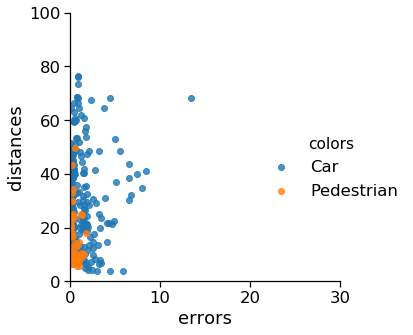

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

errors = np.abs(diff[:300])
distances = actuals[:300]
colors = classes[:300]
intToClass = {v: k for k, v in classToInt.items()}
df = pd.DataFrame(dict(errors=errors, distances=distances, colors=colors))
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.lmplot('errors', 'distances', data=df, hue='colors', fit_reg=False)
    g.set(ylim=(0, 100))
    g.set(xlim=(0, 30))
    for t in g._legend.texts: t.set_text(intToClass[int(float(t.get_text()))])
    plt.show()

In [25]:
preds[0]

8.479415669754674

In [26]:
actuals[0]

8.733533076596206

In [27]:
diff[0]

-0.25411740684153195